In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import pandas as pd
import math

In [2]:
def features(x,y):
    
    '''
    Extracts the features from a dataset defined by (x,y)
    '''
    
    x_orig = x.copy()                 # The original list of x-values without changes
    
    x = strict_increase(x)            # Makes sure that x is a strict increase (necessary if repeats are present)
    
    m = len(x)                        # Number of data points
    
    '''
    First, a smooth curve is generated
    '''
    
    if m == 2:                        # If there are two points, a linear polynomial is used
        sp = polynomial(x,y,1)
    
    elif m == 3:                      # If there are three points, a quadratic polynomial is used
        sp = polynomial(x,y,2)
    
    elif m == 4:                      # If there are four points, a cubic polynomial is used
        sp = polynomial(x,y,3)
        
    else:                             # If m>= 5, a cubic spline is generated (see the function 'smoothcurve' for more information)
        sp = smoothcurve(x,y)
    
    '''
    The shape of this curve is extracted and based on this, it can be seen whether the curve needs to be simplified or not
    '''
    
    shape1, shape2, extremes = primitives(sp,x)      # Lists containing the information on the shape of the curve (see the function 'primitives' for more information)
    p_string = primitivesstring(shape1,shape2)       # List of strings with letters representing the primitives (see the function 'primitivesstring' for more information)
    too_complex = primcomplex(p_string)              # Based on the list of strings, it decided whether the curve is too complex or not (see the function 'too_complex' for more information)
    
    sp = simplifysmoothcurve(x,y,sp,too_complex)     # The curve can now be simplified if necessary (see the function 'simplifysmoothcurve' for more information)
    
    A, B, C, sign_x = log_fit(x_orig, y)
    
    choose_log = log_simplify(x, y, sp, A, B, C, sign_x)
    
    if choose_log == True:
        
        shape1, shape2, extremes = log_primitives(A, B, C, sign_x, x)      # Shapes of the simplified curve
        p_string = primitivesstring(shape1,shape2)                         # Primitives of the simplified cuve
    
        log_primitivesvisual(x, y, A, B, C, sign_x, extremes, p_string)    # The curve is now visualised (see the function 'primitivesvisual' for more information)
    
        extremes = np.array(extremes)
    
        y_values = A*np.log(sign_x*(extremes - C)) + B
        
    else:
    
        shape1, shape2, extremes = primitives(sp,x)      # Shapes of the simplified curve
        p_string = primitivesstring(shape1,shape2)       # Primitives of the simplified cuve
    
        primitivesvisual(x,y,sp,extremes,p_string)       # The curve is now visualised (see the function 'primitivesvisual' for more information)
    
        extremes = np.array(extremes)
    
        y_values = sp(extremes)                          # y-values at the extremes between the primitives
    
    extrema = extremum(p_string)
    
    '''
    Important information is now printed: the primitives, the x-values at their extremes and the y-values at their extremes
    '''
    
    print("Primitives:", p_string)
    print()
    
    print("Extremes of the primitives:", extremes)
    print()
    
    print("Value at extremes of the primitives:", y_values)
    print()
    
    print("Extrema:", extrema)
    print()
    
    return p_string, extremes, y_values, extrema

In [3]:
def strict_increase(x):
    
    '''
    Python's UnivariateSpline algorithm only works if x is strictly increasing, so it does not work when repeats are present
    
    To avoid this, a very small value is added to x-values if it is equal to another x-value
    
    For example:
    
    x = [1, 1, 1, 2]
    
    x[1] is first compared to x[0]: they are equal, so x[1] is increased by a small value
    x[2] must then be compared to x[0] as well, as x[1] was changed
    
    This means that x[i] must be compared to x[i-1-nr_repeats] with nr_repeats the number of repeats that were already found
    '''
    
    delta_x = x[-1] - x[0]           # x_max - x_min, the range of x-values
    
    nr_repeats = 0                   # Number of repeats of a certain x-value
    
    for i in range(1,len(x)):
        
        if x[i] == x[i-1-nr_repeats]:                   # x[i] is compared to x[i-1-nr_repeats] 
            
            nr_repeats +=1                              # The number of repeats increases by 1
            
            x[i] += nr_repeats * delta_x * 10**-10      # Delta_x * 10^(-10) is added to the value, multiplied with nr_repeats to make sure that every repeat has a different value
        
        else:
            
            nr_repeats = 0           # nr_repeats is set to 0 once a new x-value is encountered
    
    return x

In [4]:
def polynomial(x,y,k):
    
    '''
    Draw a curve through a dataset defined by (x,y) using a polynomial
    
    If k = 1: Straight line is fitted through data
    If k = 2: Quadratic polynomial is fitted through data
    If k = 3: Cubic polynomial is fitted through data
    '''
    
    m = len(x)                       # Number of points in dataset
    s = m                            # Default smoothing factor is equal to the number of data points m
    done = False                     # Determines if the algorithm is finished or not
    
    '''
    A first spline is calculated
    If it has two knots, the algorithm is finished
    '''
    
    sp = UnivariateSpline(x,y,None,[None,None],k,s)           # A new spline is calculated using the new residual s
    nr_knots = len(sp.get_knots())                            # Number of knots of the new spline
    
    if nr_knots == 2:
        
        return sp
        
    '''
    If the number of knots is higher than 2, a higher smoothing factor is needed
    The smoothing factor is doubled until the number of knots equals 2
    '''
    
    while not done:
        
        s *= 2                         # Residual is doubled
        
        sp = UnivariateSpline(x,y,None,[None,None],k,s)           # A new spline is calculated using the new residual s
        nr_knots = len(sp.get_knots())                            # Number of knots of the new spline
        
        if nr_knots == 2:                                         # Algorithm is finished if nr_knots equals 2
            done = True                                              
    
    return sp

<font size="4"><center>Smooth curve algorithm:</center></font>

<br>
<br>

<font size="3"><center>GOAL:</center></font>

<font size="3"><center>Out of all the splines in the figure, find the realistic spline with the lowest smoothing factor possible</center></font>

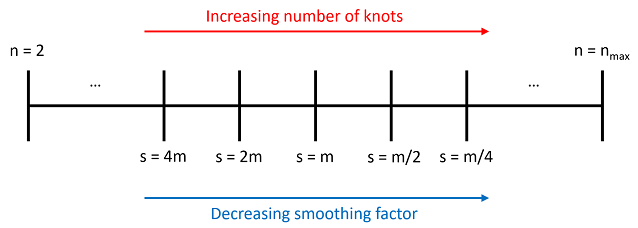
 
<br>
<br>
<br>

<font size="3"><center>IMPLEMENTATION:</center></font>

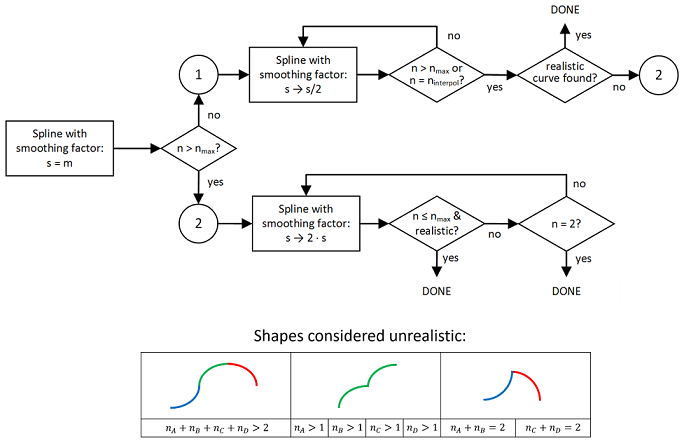

In [5]:
def smoothcurve(x,y):
    
    '''
    Draw a smooth curve through a dataset defined by (x,y) using a cubic spline
    
    This is done using two loops:
    - One which halves the smoothing factor of the spline in each step
    - One which doubles the smoothing factor of the spline in each step
    
    The former loop is controlled by the Boolean 'done1' and the latter loop is controlled by the Boolean 'done2'
    '''
    
    k = 3                            # Degree of cubic spline
    
    m = len(x)                       # Number of points in dataset
    s = m                            # Default smoothing factor is equal to the number of data points m
    
    done1, done2 = False, False      # The loops are not done at the beginning
    
    '''
    First of all, a maximal number of knots must be set for the spline
    
    For a cubic spline, this is a function of the number of data points and is equal to or greater than 2
    
    The first two knots of a spline are always placed at the beginning and at the end of the considered interval
    New knots are placed one by one in the middle of the interval with the highest residual sum of squares
    '''
    
    if m <= 9:           
        
        nr_knots_max = m - 2         # If m <= 9 (low number of data points), the maximal number of knots is equal to m - 2
    
    else:                            # If m > 9, the maximal number of knots is set to 7, as after thorough testing,
                                     # it was verified that this is enough to capture possible shapes expected in catalytic datasets
        nr_knots_max = 7             
                                
    nr_knots_interpol = m - 2        # Number of knots needed for interpolation; it is used to make sure that algorithm stops once this number is reached
    
    '''
    A first spline is calculated using the default smoothing factor equal to the number of data points
    '''
    
    
    sp_orig = UnivariateSpline(x,y,None,[None,None],k,s)   # First spline with smoothing factor s = m
    nr_knots = len(sp_orig.get_knots())                    # Number of knots of the spline
    
    shape1, shape2, extremes = primitives(sp_orig,x)       # Shapes of the spline
    p_string = primitivesstring(shape1,shape2)             # Primitives of the spline
    too_complex_orig = primcomplex(p_string)               # Indicates whether the spline is too complex or not
    
    if nr_knots > nr_knots_max:       # If the number of knots surpasses nr_knots_max, the loop which halves the smoothing factor is not entered
        
        done1 = True
        
    if nr_knots == 2:                 # If the number of knots equals 2, the loop which doubles the smoothing factor is not entered
        
        done2 = True
        
    '''
    The first spline has now been calculated using the default value of the smoothing factor
    A while-loop is now started to change this smoothing factor
    
    In the first loop, the number of knots of the first spline is lower than or equal to nr_knots_max and
    the smoothing factor is halved until nr_knots_max is surpassed
    
    In each step, the spline is stored in the list 'splines'
    '''
    
    if done1 == False:                       # The loop is entered if 'done1' is False
        
        splines = [sp_orig]                  # List of splines
        complexity = [too_complex_orig]      # List of Booleans indiciting whether the spline is too complex or not
        
        while not done1:
        
            s /= 2                           # Residual is halved
        
            sp = UnivariateSpline(x,y,None,[None,None],k,s)           # A new spline is calculated using the new residual s
            nr_knots = len(sp.get_knots())                            # Number of knots of the new spline
    
            shape1, shape2, extremes = primitives(sp,x)    # Shapes of the new spline
            p_string = primitivesstring(shape1,shape2)     # Primitives of the new spline
            too_complex = primcomplex(p_string)            # Complexity of the new spline
        
            if nr_knots > nr_knots_max:               # Algorithm is finished if nr_knots_max is surpassed
            
                done1 = True                          # The last calculated spline has a number of knots which is too high, so it is not added to the list of splines

            elif nr_knots == nr_knots_interpol:       # Algorithm is finished if the number of knots equals the number of knots needed for interpolation
            
                done1 = True                          # The last calculated spline has a number of knots which is not too high, so it is added to the list of splines
                
                splines.append(sp)
                complexity.append(too_complex)
        
            else:                                     # Otherwise, the spline is added to the list of splines
            
                splines.append(sp)
                complexity.append(too_complex)
                
        '''
        The list of splines has been generated, so now the algorithm looks for the index of the last spline which is not considered unrealistic,
        the last spline with too_complex == False
        '''
     
        index_optimal_spline = -1                     # The algorithm starts with an index outside the range of indices
    
        for i in range(0, len(splines)):              # Each spline in the list of splines is considered
        
            if complexity[i] == False:                # If the spline has a realistic shape, the index is updated
            
                index_optimal_spline = i
    
        if index_optimal_spline != -1:                # If an index was found, the corresponding spline is returned
    
            return splines[index_optimal_spline]
    
    '''
    In the second loop, the smoothing factor is halved until it has two knots
    A cubic spline with two knots is a cubic polynomial, so further changes are impossible
    
    The first calculated spline which has a realistic shape is returned, as that is the most accurate spline with a realistic shape
    '''
    
    if done2 == False:                       # The loop is entered if 'done2' is False
    
        while not done2:
        
            s *= 2                           # Residual is halved
        
            sp = UnivariateSpline(x,y,None,[None,None],k,s)            # A new spline is calculated using the new residual s
            nr_knots = len(sp.get_knots())                             # Number of knots of the new spline
        
            shape1, shape2, extremes = primitives(sp,x)    # Shapes of the new spline
            p_string = primitivesstring(shape1,shape2)     # Primitives of the new spline
            too_complex = primcomplex(p_string)            # Complexity of the new spline        
        
            if nr_knots <= nr_knots_max and too_complex == False:    # If a spline is found with a number of knots below nr_knots_max and with a realistic shape, it is returned 
            
                return sp
            
            elif nr_knots == 2:                            # Algorithm is finished if the number of knots equals 2
                
                done2 = True
    
    '''
    If no spline was found with a realistic shape, sp_orig (default smoothing factor) is returned.
    '''
    
    return sp_orig

<font size="3"><center>Simplify smooth curve algorithm:</center></font>

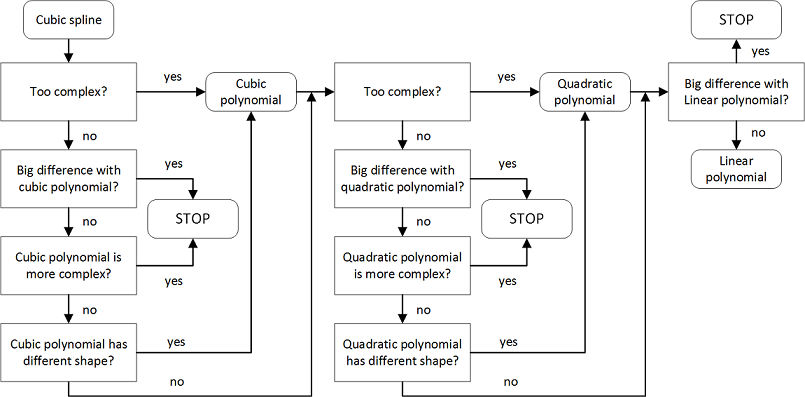

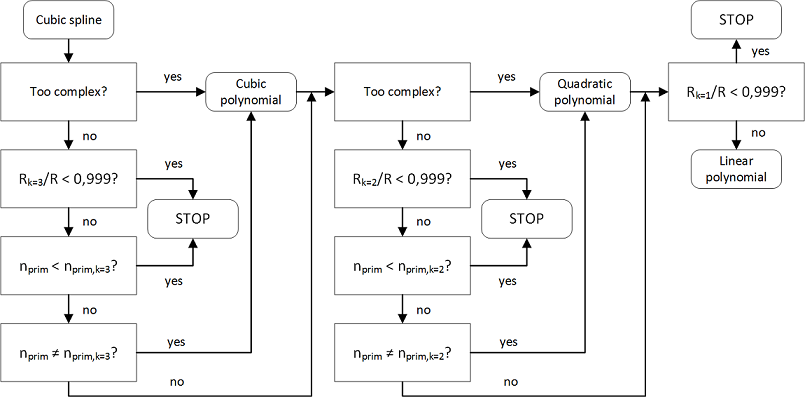


In [6]:
def simplifysmoothcurve(x,y,sp,too_complex):
    
    '''
    Generates cubic spline for a single dataset and simplifies it to a linear, quadratic or cubic polynomial if necessary
    '''
    
    m = len(x)                    # Number of data points
    n = len(sp.get_knots())       # Number of knots
    
    shape1_s, shape2_s, extremes_s = primitives(sp,x)    # Shape of the original curve
    Rs = rvalue(sp,x)                                    # R-value of the original curve
    
    p_string_s = primitivesstring(shape1_s, shape2_s)
    nr_ABCD_s = p_string_s.count("A") + p_string_s.count("B") + p_string_s.count("C") + p_string_s.count("D")
    
    if n == 2 and m >= 4:         # If there are only two knots and m >= 4, the curve is a cubic polynomial
        R3 = Rs                   # The R-value of the cubic polynomial is the same as the one calculated before
    
    elif m == 3:                  # If there are only two knots and m = 3, the curve is a quadratic polynomial
        R2 = Rs                   # The R-value of the quadratic polynomial is the same as the one calculated before
    
    '''
    If the number of knots is higher than two, the original curve is a cubic spline, so in the following section, the
    current curve is compared to a cubic polynomial
    
    If the number of knots is equal to two, this part of the code is skipped as the curve is already a cubic polynomial
    or a polynomial of a lower degree
    '''
    
    if n != 2:
        
        sp3 = polynomial(x,y,3)                                  # Cubic polynomial
        shape1_3, shape2_3, extremes_3 = primitives(sp3,x)       # Shape of the cubic polynomial
        R3 = rvalue(sp3,x)                                       # R-value of the cubic polynomial
        
        p_string_3 = primitivesstring(shape1_3, shape2_3)
        nr_ABCD_3 = p_string_3.count("A") + p_string_3.count("B") + p_string_3.count("C") + p_string_3.count("D")
        
        if too_complex == True:                                # If too_complex is True, the simplification is forced
            
            sp = sp3                                           # sp is updated with 'sp3'
            shape1_s, shape2_s = shape1_3, shape2_3
            Rs = R3
            too_complex = primcomplex(primitivesstring(shape1_s,shape2_s))
        
        elif R3/Rs < 0.998 or nr_ABCD_3 > nr_ABCD_s:           # If the difference in R-value is too big, the curve is not simplified and the algorithm is finished
                                                               # (the value of 0,998 was obtained after testing many examples)
            return sp                                          # The algorithm is also stopped if the cubic polynomial is more complex than sp (if it is represented by more primitives A, B, C and D)
        
        elif shape1_3 != shape1_s or shape2_3 != shape2_s:     # If the shape of the cubic polynomial and sp are different, sp is updated
                                                               # If they have the same shape, sp is not updated to keep the more accurate curve
            sp = sp3
            shape1_s, shape2_s = shape1_3, shape2_3
            Rs = R3
            too_complex = primcomplex(primitivesstring(shape1_s,shape2_s))
    
    '''
    The curve sp is now compared to a quadratic polynomial
    
    This step is skipped if the curve is already quadratic or linear (m < 4)
    '''
    
    if m >= 4:
        
        sp2 = polynomial(x,y,2)                                # Quadratic polynomial
        shape1_2, shape2_2, extremes_2 = primitives(sp2,x)     # Shape of the quadratic polynomial
        R2 = rvalue(sp2,x)                                     # R-value of the quadratic polynomial
        
        p_string_2 = primitivesstring(shape1_2, shape2_2)
        nr_ABCD_2 = p_string_2.count("A") + p_string_2.count("B") + p_string_2.count("C") + p_string_2.count("D")
        
        if too_complex == True:                                # If too_complex is True, the simplification is forced
            
            sp = sp2                                           # sp is updated with 'sp2'
            shape1_s, shape2_s = shape1_2, shape2_2
            Rs = R2
            too_complex = primcomplex(primitivesstring(shape1_s,shape2_s))
            
        elif R2/R3 < 0.998 or nr_ABCD_2 > nr_ABCD_s:           # If the difference in R-value is too big, the curve is not simplified and the algorithm is finished
                                                               # (the value of 0,998 was obtained after testing many examples)
            return sp                                          # The algorithm is also stopped if the quadratic polynomial is more complex than sp (if it is represented by more primitives A, B, C and D)
        
        elif shape1_2 != shape1_s or shape2_2 != shape2_s:     # If the shape of the quadratic polynomial and sp are different, sp is updated
                                                               # If they have the same shape, sp is not updated to keep the more accurate curve
            sp = sp2
            shape1_s, shape2_s = shape1_2, shape2_2
            Rs = R2
            too_complex = primcomplex(primitivesstring(shape1_s,shape2_s))
            
    '''
    The curve sp is now compared to a linear polynomial
    
    This step is skipped if the curve is already  linear (m = 2)
    '''
    
    if m >= 3:
        
        sp1 = polynomial(x,y,1)                               # Linear polynomial
        shape1_1, shape2_1, extremes_1 = primitives(sp1,x)    # Shape of the linear polynomial
        R1 = rvalue(sp1,x)                                    # R-value of the linear polynomial
        
        if len(shape1_s) == 1 and shape1_s[0] == shape1_1[0] and shape2_s[0] == shape2_1[0]:      # If sp is already linear, it is simplified to a linear polynomial for visualisation
            return sp1
        
        if R1/R2 < 0.998:         # The curve is simplified if the difference in R-value is small
            return sp             # Otherwise, sp is kept
        
        else:
            return sp1
    
    return sp                     # Nothing is done when m = 2

In [7]:
def rvalue(sp, x):
   
    '''
    Calculates multiple correlation coefficient R of a spline fit
    '''
    
    ssy = np.sum(np.square(sp(x)))             # Sum of squares of prediction
    sse = sp.get_residual()                    # Sum of squares of error
    R = np.sqrt(ssy/(sse+ssy))                 # Multiple correlation coefficient
    
    return R

In [8]:
def primitives(sp, x):
    
    '''
    Returns two lists storing the evolution of the signs of the first and second derivative of a spline, and a list with the extremes of the intervals
    
    For example:
    
    shape1 = [1, -1, 0, 1]
    shape2 = [1, 1, 0, 0]
    extremes = [0, 0.5, 1, 2.5, 4]
    
    Between x-values 0 and 0.5: first derivative is positive (1), second dertivative is positive (1)
    Between x-values 0.5 and 1: first derivative is negative (-1), second derivative is positive (1)
    Between x-values 1 and 2.5: first derivative is close to zero (0), second dertivative is close to zero (0)
    Between x-values 2.5 and 4: first derivative is positive (1), second derivative is close to zero (0)
    '''
    
    m = len(x)                                # Number of data points
    n = len(sp.get_knots())                   # Number of knots of the spline
    
    '''
    The first step is to determine in which points the derivatives will be calculated and to determine which values will be
    used to normalise the derivatives.
    
    The derivatives are calculated in 100 equidistant points in the considered interval (100 is enough to extract the primitives)
    
    The first derivative is normalised by multiplying it with (x_max - x_min)/(y_max - y_min)
    The second derivative is normalised by multiplying it with (x_max - x_min)/(y_max - y_min)
    '''
    
    xs = np.linspace(x[0],x[m-1],100)         # Points where derivatives are calculated
    x_m = x[m-1] - x[0]                       # x_max - x_min
    y_m = max(sp(xs)) - min(sp(xs))           # y_max - y_min
    
    '''
    A function exists to calculate the derivatives of the UnivaririateSpline objects, but the k'th derivative can only be
    calculated if the degree of the spline is at least k, so for a linear spline the second derivative cannot be calculated.
    If this is still done, a ValueError will be returned
    
    The following code is used for splines of a degree of at least 2. For linear splines, an error will be returned and
    the code goes to a later section of the code which is meant to handle exceptions (except ValueError)
    '''
    
    try:
        
        der1_sp, der2_sp = sp.derivative(1), sp.derivative(2)           # First and second derivative of spline
        der1, der2 = der1_sp(xs[0]), der2_sp(xs[0])                     # First and second derivative of spline in first point
        
        shape1, shape2 = [], []                         # Lists containing the signs
        extremes = []                                   # List containing the extremes of the intervals
        
        '''
    The signs of the derivatives are now calculated. If the absolute value of the normalised derivative is below a certain value,
    it is considered equal to 0
    
    If the absolute value of the first derivative is lower than 0.5, it is considered 0
    If the absolute value of the second derivative is lower than 1, it is considered 0
    
    If the first derivative equals 0, both derivatives are set to 0
        '''
        
        if np.abs(der1)*x_m/y_m < 0.5:                # If the normalised first derivative is lower than 0.5, it's considered 0
            sign_der1 = 0
            
        else:
            sign_der1 = int(np.sign(der1))
            
        if np.abs(der2)*np.square(x_m)/y_m < 0.5 or sign_der1 == 0:       # If the normalised derivative is lower than 1, it's considered 0
            sign_der2 = 0                                               # If the first derivative equals 0, both derivatives are set to 0
        
        else:
            sign_der2 = int(np.sign(der2))
        
        '''
    A for-loop is now started to calculate the derivative in all points and based on this, the signs are added to the lists of signs
    
    The signs are added to lists of signs when at least two consecutive points have the same sign
    To do this, the value of 'sign_change' becomes equal to True when the sign changed in the previous point
        '''
        
        sign_change = True                                              # If the sign changes, this becomes True. It is used to make sure that two consecutive point have the same primitive
        
        for i in range(1,100):                                          # If one of the signs changes, the lists are updated with the new signs
            
            der1_new, der2_new = der1_sp(xs[i]), der2_sp(xs[i])         # The derivatives in point i      
            
            if np.abs(der1_new)*x_m/y_m < 0.5:                          # The previous equations for the derivatives are repeated for point i
                sign_der1_new = 0
            
            else:
                sign_der1_new = int(np.sign(der1_new))
            
            if np.abs(der2_new)*np.square(x_m)/y_m < 0.5 or sign_der1_new == 0:
                sign_der2_new = 0
            
            else:
                sign_der2_new = int(np.sign(der2_new))
            
            if sign_der1_new != sign_der1 or sign_der2_new != sign_der2:    # If sign changes, sign_change becomes True, or when i == 1 as this is the first point in the loop
                sign_change = True
            
            elif sign_change == True:                                   # Two consecutive points have the same derivative
                                                                        # (this elif-statement can only be reached if the previous once was False,
                if shape1 == []:                                        # this means that there was no sign change this time)
                    extremes.append(x[0])
                    shape1.append(sign_der1_new)                        # If the shape-list is still empty, x[0] (the first point) is added to the list 'extremes'
                    shape2.append(sign_der2_new)
                
                elif shape1[-1] != sign_der1_new or shape2[-1] != sign_der2_new:
                    extremes.append(xs[i-1])                 
                    shape1.append(sign_der1_new)                        # If the shape-list is not empty, point i-1 is added to the list 'extremes'
                    shape2.append(sign_der2_new)                        # Neither of the if-statement are reached if signs are the same as for the signs in the shape-list
                                                                        # as there is no need to have the same primitive twice consecutively
                
                sign_change = False         # 'sign_change' is set to False until a new sign change occurs
            
            sign_der1, sign_der2 = sign_der1_new, sign_der2_new         # Stored as der1 and der2 for the following iteration
        
        extremes.append(x[m-1])               # Final x-value is also added to the list of extremes
        
        '''
    In some cases, a flat section (derivatives both 0) represents a maximum or a minimum and it would be more intuituive
    to remove it and keep the sections next to it
        '''
        
        shape1_new, shape2_new, extremes_new = shape1.copy(), shape2.copy(), extremes.copy()
        nr_removed = 0
        
        if len(shape1) >= 3:                              # The shape-lists need to contain at least three signs for a maximum or a minimum
            
            for i in range(0,len(shape1)-2):              # signs i are compared to signs i+1 and i+2
                
                if shape1[i] == 1 and shape2[i] == -1:            # Maximum is described by first derivative: [1, 0, -1] and second derivative: [-1, 0, 1]
                    
                    if shape1[i+1] == 0 and shape2[i+1] == 0 and shape1[i+2] == -1 and shape2[i+2] == -1:
                        
                        del shape1_new[i+1-nr_removed]            # The flat sections are deleted
                        del shape2_new[i+1-nr_removed]
                        
                        t_new = (extremes[i+1] + extremes[i+2])/2     # The two extremes of the flat section are replaced by one value in the middle
                        del extremes_new[i+2-nr_removed]
                        extremes_new[i+1-nr_removed] = t_new
                        nr_removed += 1
                
                if shape1[i] == -1 and shape2[i] == 1:            # Minimum is described by first derivative: [-1, 0, 1] and second derivative [1, 0, -1]
                    
                    if shape1[i+1] == 0 and shape2[i+1] == 0 and shape1[i+2] == 1 and shape2[i+2] == 1:
                        
                        del shape1_new[i+1-nr_removed]            # The flat sections are deleted
                        del shape2_new[i+1-nr_removed]
                        
                        t_new = (extremes[i+1] + extremes[i+2])/2     # The two extremes of the flat section are replaced by one value in the middle
                        del extremes_new[i+2-nr_removed]
                        extremes_new[i+1-nr_removed] = t_new
                        nr_removed += 1
                        
        shape1, shape2, extremes = shape1_new, shape2_new, extremes_new
    
        '''
    The following code is used for linear polynomials; in this case, the polynomial is a straight line, which can
    be represented by one shape
    
    The sign of the first derivative is calculated, while the sign of the second derivative is always 0
        '''
    
    except ValueError:                             # ValueError occurs when linear spline is used
        
        der1_sp = sp.derivative(1)
        der1 = der1_sp(xs[0])                      # First derivative of spline in first point
        
        shape1, shape2 = [], []                    # List containing the signs
        extremes = []
        
        if np.abs(der1)*x_m/y_m <= 0.5:            # Only the first derivative is calculated
            sign1 = 0
        
        else:
            sign1 = int(np.sign(der1))
        
        shape1.append(sign1)                       # The signs are added to the shape-lists
        shape2.append(0)
        extremes.append(x[0])                      # The extremes of the considered interval are added to the 'extremes'-list
        extremes.append(x[m-1])
    
    return shape1, shape2, extremes

<font size="3"><center>Possible primitives:</center></font>

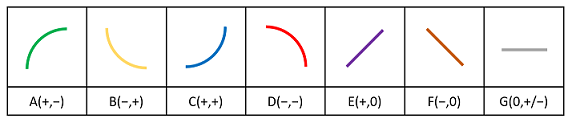

In [9]:
def primitivesstring(shape1, shape2):
    
    '''
    Creates list of strings with letters representing the primitives of the curve
    
    '''
    
    primitives = []         # List storing the strings
    n = len(shape1)         # Number of primitives
    
    for i in range(0,n):
        
        if shape1[i] == 1 and shape2[i] == -1:        # Primitive A is represented by the signs 1 and -1
            primitives.append('A')
        
        elif shape1[i] == -1 and shape2[i] == 1:      # Primitive A is represented by the signs -1 and 1
            primitives.append('B')
        
        elif shape1[i] == 1 and shape2[i] == 1:       # Primitive A is represented by the signs 1 and 1
            primitives.append('C')
        
        elif shape1[i] == -1 and shape2[i] == -1:     # Primitive A is represented by the signs -1 and -1
            primitives.append('D')
        
        elif shape1[i] == 1 and shape2[i] == 0:       # Primitive A is represented by the signs 1 and 0
            primitives.append('E')
        
        elif shape1[i] == -1 and shape2[i] == 0:      # Primitive A is represented by the signs -1 and 0
            primitives.append('F')
        
        else:                                         # Primitive G is represented by the signs 0 and 0
            primitives.append('G')
    
    return primitives

In [10]:
def primitivesvisual(x,y,sp,extremes,p_string):
    
    '''
    Visualises the features
    '''
    
    m = len(x)           # Number of data points
    n = len(extremes)      # Number of extremes
    
    xs = np.linspace(x[0],x[m-1],1000)       # Points to plot
    
    y_min, y_max = min([min(y),min(sp(xs))]), max([max(y),max(sp(xs))])    # Smallest and highest y-values reached by the spline and the data points 
    delta_y = y_max - y_min                                                # The range of y-values
    
    plt.plot(x, y, 'ro', ms=10)               # Data points are plotted in red
    
    '''
    The data points have been plotted; now, the spline and its features need to plotted
    '''
    
    for i in range(0,n-1):
        
        xs = np.linspace(extremes[i],extremes[i+1],1000)       # Points to plot for one primitive
        
        if p_string[i] == 'A':                             # If the primitive is A, the curve is plotted in green
            plt.plot(xs, sp(xs), 'g', lw=3)
        
        elif p_string[i] == 'B':                           # If the primitive is B, the curve is plotted in yellow
            plt.plot(xs, sp(xs), 'y', lw=3)
        
        elif p_string[i] == 'C':                           # If the primitive is C, the curve is plotted in blue
            plt.plot(xs, sp(xs), 'b', lw=3)
        
        elif p_string[i] == 'D':                           # If the primitive is D, the curve is plotted in red
            plt.plot(xs, sp(xs), 'r', lw=3)
        
        elif p_string[i] == 'E':                           # If the primitive is E, the curve is plotted in purple
            plt.plot(xs, sp(xs), color='#9400d3', lw=3)
        
        elif p_string[i] == 'F':                           # If the primitive is F, the curve is plotted in orange
            plt.plot(xs, sp(xs), color='#ff8c00', lw=3)
        
        else:                                              # If the primitive is G, the curve is plotted in grey
            plt.plot(xs, sp(xs), color='#808080', lw=3)
        
        xt = (extremes[i]+extremes[i+1])/2 - (extremes[n-1]-extremes[0])/40    # x-position where letter will be placed on graph
        
        if delta_y != 0:
            
            yt = y_min - 0.2*delta_y                       # y-position where letter will be placed on graph
 
        elif y_min != 0:

            yt = 0.95*y_min
            
        else:
            
            yt = -5
        
        plt.text(xt,yt,p_string[i],fontsize=15)            # Letter representing primitive is printed on graph
    
    '''
    The black vertical lines are now plotted between the primitives
    '''
    
    if delta_y != 0:
        
        yp = np.linspace(y_min - 0.2*delta_y, y_max + 0.2*delta_y, 1000)         # y points to plot in the vertical line
    
    elif y_min != 0:
        
        yp = np.linspace(0.95*y_min, 1.05*y_max, 1000)
        
    else:
        
        yp = np.linspace(-5, 5, 1000)
    
    for i in range(0,n):
        
        xp = [extremes[i]]*1000                # List with 1000 times the x-position of the line
        
        plt.plot(xp, yp, 'k', lw=2)          # Vertical line is plotted

<font size="3"><center>Smooth curve is considered too complex if one of the following conditions is satisfied:</center></font>

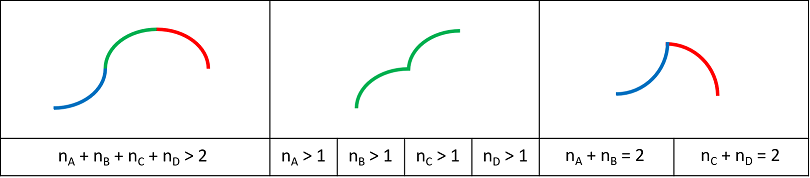

In [11]:
def primcomplex(p_string):
    
    '''
    Determines if curve is too complex or not
    '''
    
    nA = p_string.count('A')       # Number of A-primitives
    nB = p_string.count('B')       # Number of B-primitives
    nC = p_string.count('C')       # Number of C-primitives
    nD = p_string.count('D')       # Number of D-primitives
    
    if nA + nB + nC + nD > 2:                         # The curve is considered complex if there are more than two primitives of the types A, B, C or D
        return True
    
    if nA > 1 or nB > 1 or nC > 1 or nD > 1:          # The curve is considered complex if there is more than one primitive of same the type of the types A, B, C or D
        return True
    
    if nA + nB == 2 or nC + nD == 2:                  # The curve is considered complex if there are both A and B primitives, or both C and D primitives
        return True
    
    return False

In [12]:
def extremum(p_string):
    
    '''
    Determines if there is an extremum
    '''
    
    n = len(p_string)
    
    extrema = [" "]
    
    for i in range(1, n):
        
        if p_string[i-1] == "B" and p_string[i] == "C":
            
            extrema.append("minimum")
            
        elif p_string[i-1] == "A" and p_string[i] == "D":
            
            extrema.append("maximum")
        
        else:
            
            extrema.append(" ")
    
    extrema.append(" ")
    
    return extrema

In [13]:
def features_parametric(list_x,list_y):
    
    '''
    Extracts features from parametric datasets
    
    list_x is a list containing the x-values of all datasets
    list_y is a list containing the y-values of all datasets
    
    Dataset i has x-values list_x[i] and y-values list_y[i]
    '''
    
    n_list = len(list_x)        # Number of datasets
    list_x_orig = []
    
    list_sp = []                # The splines for each dataset will be stored in this list
    list_shape1 = []            # The list shape1 will be stored in this list for each dataset
    list_shape2 = []            # The list shape2 will be stored in this list for each dataset
    list_extremes = []          # The list extremes will be stored in this list for each dataset
    list_too_complex = []       # The list will indicate which splines are too complex
    
    '''
    To access the objects corresponding to dataset i, the index i must be used in the lists
    
    First, a smooth curve is generated
    '''
    
    for i in range(0,n_list):                                # Smooth curve is calculated for each dataset
        
        x_orig = list_x[i]
        list_x_orig.append(x_orig.copy())
        
        list_x[i] = strict_increase(list_x[i])               # Makes sure that x has a strict increase (necessary if repeats are present)
        
        m = len(list_x[i])                                   # Number of data points in dataset i
        
        if m == 2:
            
            sp = polynomial(list_x[i], list_y[i],1)          # If two points: linear polynomial
            
        elif m == 3:
            
            sp = polynomial(list_x[i], list_y[i],2)          # If three points: quadratic polynomial
            
        elif m == 4:
            
            sp = polynomial(list_x[i], list_y[i], 3)         # If four points: cubic polynomial
            
        else:
            
            sp = smoothcurve(list_x[i],list_y[i])                      # In other cases, a cubic spline is used
            
        list_sp.append(sp)                                             # The spline is added to the list of splines
        
        shape1, shape2, extremes = primitives(sp,list_x[i])            # Shape lists of the splines
        
        list_shape1.append(shape1)                                     # shape1 is added to the list of shape1
        list_shape2.append(shape2)                                     # shape2 is added to the list of shape2
        list_extremes.append(extremes)
        too_complex = primcomplex(primitivesstring(shape1,shape2))     # Calculates if the spline is too complex
        list_too_complex.append(too_complex)                           # Stored in list for values of 'too_complex'
        
    '''
    The smooth curve can be simplified if possible
    '''
    
    list_sp = simplifysmoothcurve_parametric(list_x,list_y,list_sp,list_too_complex,list_shape1,list_shape2,list_extremes)    # Simplification algorithm
    
    list_shape1, list_shape2, list_extremes = [], [], []          # The shape-lists will be recalculated for the new curves
    list_p_string = []                                          # The letters representing the primitives will also be generated for each curve
    list_y_extremes = []
    list_extrema = []
    
    for i in range(0,n_list):
        
        sp = list_sp[i]
        
        shape1, shape2, extremes = primitives(sp, list_x[i])      # Shape lists of the splines
        
        list_shape1.append(shape1)                      # shape1 is added to the list of shape1
        list_shape2.append(shape2)                      # shape2 is added to the list of shape2
        list_extremes.append(extremes)                      # extremes is added to the list of extremes
        
        p_string = primitivesstring(shape1,shape2)      # Lists of letters representing primitives
        list_p_string.append(p_string)                  # Added to the list containg all these lists
        
        y_extremes = sp(extremes)
        list_y_extremes.append(y_extremes)
        
        extrema = extremum(p_string)
        list_extrema.append(extrema)
        
    list_A = []
    list_B = []
    list_C = []
    list_sign_x = []
    list_choose_log = []
        
    for i in range(0,n_list):
        
        A, B, C, sign_x = log_fit(list_x_orig[i], list_y[i])
        
        list_A.append(A)
        list_B.append(B)
        list_C.append(C)
        list_sign_x.append(sign_x)
    
        choose_log = log_simplify(list_x[i], list_y[i], list_sp[i], A, B, C, sign_x)
        
        list_choose_log.append(choose_log)
        
        if choose_log == True:
            
            shape1, shape2, extremes = log_primitives(A, B, C, sign_x, list_x[i])      # Shapes of the simplified curve
            p_string = primitivesstring(shape1, shape2)                                # Primitives of the simplified cuve
    
            extremes = np.array(extremes)
    
            y_extremes = A*np.log(sign_x*(extremes - C)) + B
        
            list_shape1[i] = shape1
            list_shape2[i] = shape2
            list_extremes[i] = extremes
            list_p_string[i] = p_string
            list_y_extremes[i] = y_extremes
    
    for i in range(0,n_list):
        
        nr = i+1
        
        if list_choose_log[i] == True:
            
            log_primitivesvisual_parametric(list_x[i], list_y[i], list_A[i], list_B[i], list_C[i], list_sign_x[i], list_extremes[i], list_p_string[i])
        
        else:
            
            primitivesvisual_parametric(list_x[i],list_y[i],list_sp[i],list_extremes[i],list_p_string[i])

        print("DATASET", nr)
        print("-----------")
        print()
        print("Primitives:", list_p_string[i])
        print()
        print("Extremes of the primitives:", list_extremes[i])
        print()
        print("Value at extremes of the primitives of:", list_y_extremes[i])
        print()
        print()
        
    return list_p_string, list_extremes, list_y_extremes, list_extrema

In [14]:
def simplifysmoothcurve_parametric(list_x,list_y,list_sp,list_too_complex,list_shape1,list_shape2,list_start):
    
    '''
    Generates cubic spline for a single dataset and simplifies it to a linear, quadratic or cubic polynomial if necessary
    '''
    
    n_list = len(list_x)
    
    list_R = []
    list_nr_ABCD = []
    
    if list_too_complex.count(True) == 0:             # Check if trend is present (only if none of the curves are too complex)
        
        if list_shape1.count(list_shape1[0]) == n_list and list_shape2.count(list_shape2[0]) == n_list and list_shape2[0] != [0]:    # Trend if all curves heve the same primitives
            return list_sp
        
    for i in range(0,n_list):                   # R-value is calculated for each curve
        
        R = rvalue(list_sp[i],list_x[i])
        list_R.append(R)
        
        p_string = primitivesstring(list_shape1[i], list_shape2[i])
        nr_ABCD = p_string.count("A") + p_string.count("B") + p_string.count("C") + p_string.count("D")
        list_nr_ABCD.append(nr_ABCD)
        
    '''
    Step 1: The curve is compared to a cubic polynomial
    '''
        
    for i in range(0,n_list):       # Step 1 of the algorithm
        
        sp = list_sp[i]             # Curve i
        
        n = len(sp.get_knots())     # Number of knots of the curve
        
        if n != 2:                  # Step 1 is only performed if the curve is a cubic spline with more than two knots
            
            sp3 = polynomial(list_x[i],list_y[i],3)                     # Cubic polynomial
            
            shape1_3, shape2_3, start_3 = primitives(sp3,list_x[i])      # Shape of cubic polynomial
            
            R3 = rvalue(sp3,list_x[i])                                   # R-value of the cubic polynomial
            
            p_string_3 = primitivesstring(shape1_3, shape2_3)
            nr_ABCD_3 = p_string_3.count("A") + p_string_3.count("B") + p_string_3.count("C") + p_string_3.count("D")
            
            if list_too_complex[i] == True:                              # Simplification is forced if curve is too complex
                
                list_sp[i] = sp3                                         # All lists are updated with the cubic polynomial
                list_shape1[i], list_shape2[i] = shape1_3, shape2_3
                list_R[i] = R3
                list_too_complex[i] = primcomplex(primitivesstring(list_shape1[i],list_shape2[i]))
                list_nr_ABCD[i] = list_nr_ABCD_3
                
            elif R3/list_R[i] < 0.998 or nr_ABCD_3 > list_nr_ABCD[i]:     # the cubic spline is kept if the difference in R-value is large or the cubic polynomial has more primitives than the cubic spline
                
                continue                                                          # Do nothing                        
                
            elif shape1_3 != list_shape1[i] or shape2_3 != list_shape2[i]:        # The cubic polynomial is used unless the cubic spline and the cubic polynomial have the same shape
                
                list_sp[i] = sp3                                          # All lists are updated with the cubic polynomial
                list_shape1[i], list_shape2[i] = shape1_3, shape2_3
                list_R[i] = R3
                list_too_complex[i] = primcomplex(primitivesstring(list_shape1[i],list_shape2[i]))
                list_nr_ABCD[i] = list_nr_ABCD_3
                
    if list_too_complex.count(True) == 0:              # If a trend is found, the algorithm is stopped
        
        if list_shape1.count(list_shape1[0]) == n_list and list_shape2.count(list_shape2[0]) == n_list and list_shape2[0] != [0]:
            return list_sp
        
    '''
    Step 2: The curve is now compared to a quadratic polynomial
    '''
        
    for i in range(0,n_list):
        
        sp = list_sp[i]         # Curve i
        
        m = len(list_x[i])      # Number of data points of the curve
        
        if m >= 4:              # Step 2 is only performed if the curve has at least 4 points (the curve is a cubic spline or a cubic polynomial)
            
            sp2 = polynomial(list_x[i],list_y[i],2)                     # Quadratic polynomial
            
            shape1_2, shape2_2, start_2 = primitives(sp2,list_x[i])      # Shape of quadratic polynomial
            
            R2 = rvalue(sp2,list_x[i])                                   # R-value of quadratic polynomial
            
            p_string_2 = primitivesstring(shape1_2, shape2_2)
            nr_ABCD_2 = p_string_2.count("A") + p_string_2.count("B") + p_string_2.count("C") + p_string_2.count("D")
            
            if list_too_complex[i] == True:                              # Simplification is forced if curve is too complex
                
                list_sp[i] = sp2                                         # All lists are updated with the quadratic polynomial
                list_shape1[i], list_shape2[i] = shape1_2, shape2_2
                list_R[i] = R2
                list_too_complex[i] = primcomplex(primitivesstring(list_shape1[i],list_shape2[i]))
                
            elif R2/list_R[i] < 0.998 or nr_ABCD_2 > list_nr_ABCD[i]:      # the curve is kept if the difference in R-value is large or the quadratic polynomial has more primitives than the curve
                
                continue                                                           # Do nothing 
                
            elif shape1_2 != list_shape1[i] or shape2_2 != list_shape2[i]:         # The quadratic polynomial is used unless the curve and the quadratic polynomial have the same shape
                
                list_sp[i] = sp2                                                   # All lists are updated with the quadratic polynomial
                list_shape1[i], list_shape2[i] = shape1_2, shape2_2
                list_R[i] = R2
                list_too_complex[i] = primcomplex(primitivesstring(list_shape1[i],list_shape2[i]))
                
    if list_too_complex.count(True) == 0:                # If a trend is found, the algorithm is stopped
        
        if list_shape1.count(list_shape1[0]) == n_list and list_shape2.count(list_shape2[0]) == n_list and list_shape2[0] != [0]:
            return list_sp
        
    '''
    Step 3: The curve is now compared to a linear polynomial
    '''
        
    for i in range(0,n_list):
        
        sp = list_sp[i]       # Curve i
        
        m = len(list_x[i])    # Number of data points of the curve
        
        if m >= 3:            # Step 3 is only performed if the curve has at least 3 points (the curve is not already linear)
            
            sp1 = polynomial(list_x[i],list_y[i],1)                    # Linear polynomial
            
            shape1_1, shape2_1, start_1 = primitives(sp1,list_x[i])     # Shape of the linear polynomial
            
            R1 = rvalue(sp1,list_x[i])                                  # R-value of the linear polynomial
            
            if shape1_1 == list_shape1[i] and shape2_1 == list_shape2[i]:     # If the curve has the same shape is the linear polynomial, it is replaced by the linear polynomial for visual reasons
                
                list_sp[i] = sp1
                
            elif R1/list_R[i] < 0.998:    # If the difference in R-value is large, the original curve is kept
                
                continue                  # Do nothing
                
            else:                         # Otherwise, the curve is simplified to a linear polynomial
                
                list_sp[i] = sp1
                
    return list_sp

In [15]:
def primitivesvisual_parametric(x,y,sp,extremes,p_string):
    
    '''
    Visualisation of the parametric datasets:
    Same method as for non-parametric datasets, but without vertical black lines and letters
    '''
    
    m = len(x)             # Number of data points
    
    n = len(p_string)      # Number of primitives
    
    xs = np.linspace(x[0],x[m-1],1000)       # Points to plot
    
    plt.plot(x, y, 'ro', ms=10)               # Data points are plotted in red
    
    for i in range(0,n):
        
        xs = np.linspace(extremes[i],extremes[i+1],1000)       # Points to plot for one primitive
        
        if p_string[i] == 'A':                             # If the primitive is A, the curve is plotted in green
            plt.plot(xs, sp(xs), 'g', lw=3)
        
        elif p_string[i] == 'B':                           # If the primitive is B, the curve is plotted in yellow
            plt.plot(xs, sp(xs), 'y', lw=3)
        
        elif p_string[i] == 'C':                           # If the primitive is C, the curve is plotted in blue
            plt.plot(xs, sp(xs), 'b', lw=3)
        
        elif p_string[i] == 'D':                           # If the primitive is D, the curve is plotted in red
            plt.plot(xs, sp(xs), 'r', lw=3)
        
        elif p_string[i] == 'E':                           # If the primitive is E, the curve is plotted in purple
            plt.plot(xs, sp(xs), color='#9400d3', lw=3)
        
        elif p_string[i] == 'F':                           # If the primitive is F, the curve is plotted in orange
            plt.plot(xs, sp(xs), color='#ff8c00', lw=3)
        
        else:                                              # If the primitive is G, the curve is plotted in grey
            plt.plot(xs, sp(xs), color='#808080', lw=3)

In [16]:
def log_fit(x, y):
    
    '''
    Fits logarithm to a dataset defined by the lists x and y
    
    The fitted function is:
    
    y = A*ln(±(x-C)) + B
    
    The algorithm returns the values for the constants A, B and C, and the sign before (x-C)
    '''
    
    x_orig = x.copy()             # Original unchanged list of x-values
    y_orig = y.copy()             # Original unchanged list of y-values
    
    x = strict_increase(x)        # x now consists of a strict increase
    
    x = np.array(x)               # list x is turned into a Numpy-array
    y = np.array(y)               # list y is turned into a Numpy-array
    
    m = len(x)
    
    '''
    First, the function y = A*ln(x-C) + B is fitted to the data
    
    C is a constant which is slightly lower than x_min, the lowest x-value
    '''
    
    C_plus = estimate_C(x_orig, y_orig, 1)        # A value for the constant C is estimated
    
    ln_x = np.log(x - C_plus)                     # ln(x - C) is calculated
    
    sp = polynomial(ln_x,y,1)                     # y = A*ln(x - C) + B is now fitted to obtain the parameters A and B
    
    B_plus = sp([0])                              # y = A*0 + B equals the parameter B
    
    A_plus = sp([1]) - B_plus                     # A = (y - B)/ln(x - C); the value 1 is arbitrarily chosen for ln(x - C) to calculate this

    res_plus = log_residual(x, y, A_plus, B_plus, C_plus, 1)      # The residual is calculated for this logarithmic fit
    
    '''
    Then, the function y = A*ln(-(x-C)) + B is fitted to the data
    
    C is now a constant which is slightly higher than x_max, the highest x-value
    '''
    
    C_min = estimate_C(x_orig, y_orig, -1)        # A value for the constant C is estimated
    
    x = np.array(list(reversed(x)))               # The lists x and y are reversed, as x will be multiplied by -1 later
    y = np.array(list(reversed(y)))               # and x must increase for the UnivariateSpline algorithm
    
    ln_x = np.log(-(x - C_min))                   # ln(-(x - C)) is calculated
    
    sp = polynomial(ln_x,y,1)                     # y = A*ln(-(x - C)) + B is now fitted to obtain the parameters A and B
    
    B_min = sp([0])                               # y = A*0 + B equals the parameter B
    
    A_min = sp([1]) - B_min                       # A = (y - B)/ln(-(x - C)); the value 1 is arbitrarily chosen for ln(-(x - C)) to calculate this
        
    res_min = log_residual(x, y, A_min, B_min, C_min, -1)         # The residual is calculated for this logarithmic fit
    
    if res_min > res_plus:                        # If the logarithm y = A*ln(x-C) + B has a better fit than A*ln(-(x-C)) + B,
                                                  # The results of the former are returned
        return A_plus, B_plus, C_plus, 1
    
    else:                                         # Otherwise, the results for the latter are returned
        
        return A_min, B_min, C_min, -1

In [17]:
def remove_repeats_at_extremes(x, y):
    
    '''
    If there are points with the x-values x_min or x_max, they are replaced by one points with the average of
    their corresponding y-values
    
    For example:
    
    x = [1,1,1,2,3,4,4]
    y = [1,2,3,4,4,5,7]
    
    New lists:
    
    x = [1,2,3,4]
    y = [2,4,4,6]
    '''
    
    m = len(x)
    
    '''
    First, all points with the value x_min are checked
    
    x_min corresponds to the first x-value x[0]
    '''
    
    y_tot = y[0]              # The y-values of all points with x-value x_min will be added to this sum
    
    i = 1                     # Counts how many points have the x-value x_min
    
    while x[1] == x[0] or abs((x[1] - x[0])/x[0]) < 10**-6 or abs((x[1] - x[0])/x[1]) < 10**-6:       # If x[1] equals x[0], the point with index 1 (second point) must be removed
        
        y_tot += y[1]         # y[1] is added to the sum of the y-values
        
        del x[1]              # The point with index 1 is removed
        del y[1]              # In the next iteration, a new point will have index 1
        
        i += 1                # The counter i is updated
        
    y[0] = y_tot/i            # The average of the y-values of all points with x-value x_min
    
    '''
    Next, all points with the value x_max are checked
    
    x_max corresponds to the last x-value x[-1]
    '''
    
    y_tot = y[-1]             # The y-values of all points with x-value x_max will be added to this sum
    
    i = 1                     # Counts how many points have the x-value x_max
    
    while x[-2] == x[-1] or abs((x[-2] - x[-1])/x[-1]) < 10**-6 or abs((x[-2] - x[-1])/x[-2]) < 10**-6:     # If x[-2] equals x[-1], the point with index -2 (second to last point) must be removed
        
        y_tot += y[-2]        # y[-2] is added to the sum of the y-values
        
        del x[-2]             # The point with index -2 is removed
        del y[-2]             # In the next iteration, a new point will have index -2
        
        i += 1                # The counter i is updated
        
    y[-1] = y_tot/i           # The average of the y-values of all points with x-value x_max
    
    return x, y

In [18]:
def estimate_C(x, y, sign_x):
    
    '''
    An equation is used to estimate C in y = A*ln(±(x-C)) + B
    
    -------------------------------------------------------------------------
    
    For y = A*ln(x-C) + B, the equation is:
    
    C = ( x3 - x1 * exp(k) ) / ( 1 - exp(k) )   with   k = (y3 - y1) / (y2 - y3) * ln(α)
    
    In this equation, x1 and x3 represents the first and last x-value in the considered interval respectively.
    
    x2 is a point between these two, which can also be written as x2 = x1 + α*(x3 - x1) = α*x3 + (1-α)*x1
    
    yi represents the y-value corresponding to xi.
    
    This equation estimates the C-value necessary to to fit an exponential between three points and was derived
    under the assumption that x3 - C >> x1 - C, which means that x1 is relatively close to C
    
    -------------------------------------------------------------------------
    
    For y = A*ln(-(x-C)) + B, the equation is:
    
    C = ( x1 - x3 * exp(k) ) / ( 1 - exp(k) )   with   k = (y1 - y3) / (y2 - y1) * ln(1 - α)
    
    This equation was derived under the assumption that C - x1 >> C - x3, which means that x3 is relatively close to C
    
    --------------------------------------------------------------------------
    
    To constant C is estimated for all data points (x2,y2) with an x-value between x1 and x3
    
    The average of the different C-values is then taken as the final estimate.
    '''
    
    x, y = remove_repeats_at_extremes(x, y)  # Repeats are removed at the extremes of the considered intervals, see the function for more information
    
    m = len(x)           # Number of data points
    
    C_est = []           # The estimates for C are stored in this list
    
    for i in range(1, m-1):
        
        alpha = (x[i] - x[0])/(x[-1] - x[0])                    # Calculate α: x2 = x1 + α*(x3 - x1) ⇒ α = (x2 - x1)/(x3 - x1)
        
        if sign_x == 1:                                        
        
            k = np.log(alpha)*(y[-1] - y[0])/(y[i] - y[-1])     # The factor k is calculated as an intermediate calculation
        
            C = (x[-1] - x[0]*np.exp(k))/(1 - np.exp(k))        # C is estimated
            
        else:
            
            k = np.log(1 - alpha)*(y[0] - y[-1])/(y[i] - y[0])  # The factor k is calculated as an intermediate calculation
        
            C = (x[0] - x[-1]*np.exp(k))/(1 - np.exp(k))        # C is estimated
        
        if math.isnan(C) == False and C > x[0] - (x[-1] - x[0]) and C < x[-1] + (x[-1] - x[0]):
            
            C_est.append(C)                    # The estimation is added to C_est
        
    if sign_x == 1 and len(C_est) == 0:      
        
        return x[0] - 10**-8*(x[-1] - x[0])
    
    elif sign_x == -1 and len(C_est) == 0:
    
        return x[-1] + 10**-8*(x[-1] - x[0])
    
    else:
        
        C_est_avg = sum(C_est)/len(C_est)      # The average of the estimates is taken
    
    '''
    For y = A*ln(x-C) + B, C cannot be equal to or larger than the smallest x-value x1,
    as the logarithm cannot be calculated if x - C ≤ 0
    
    For this reason, C is estimated as x1 - 10^(-8)*(x3 - x1) if C ≥ x1
    
    ---------------------------------------------------------
    
    For y = A*ln(-(x-C)) + B, C cannot be equal to or smaller than the largest x-value x3,
    as the logarithm cannot be calculated if x - C ≥ 0
    
    For this reason, C is estimated as x3 + 10^(-8)*(x3 - x1) if C ≤ x3
    '''
    
    if sign_x == 1 and C_est_avg > x[0] - 10**-8*(x[-1] - x[0]):      
        
        return x[0] - 10**-8*(x[-1] - x[0])
    
    elif sign_x == -1 and C_est_avg < x[-1] + 10**-8*(x[-1] - x[0]):
    
        return x[-1] + 10**-8*(x[-1] - x[0])
    
    else:
    
        return C_est_avg

In [19]:
def log_residual(x, y, A, B, C, sign_x):
    
    '''
    Calculates the residual of a logarithmic fit
    '''
    
    m = len(x)
    
    res_tot = 0
    
    for i in range(0, m):
        
        y_pred = A*np.log(sign_x*(x[i] - C)) + B
        
        res = (y[i] - y_pred)**2
        
        res_tot += res
        
    return res_tot

In [20]:
def log_primitives(A, B, C, sign_x, x):
    
    '''
    Returns two lists storing the evolution of the signs of the first and second derivative of a logarithmic function, and a list with the extremes of the intervals
    
    For example:
    
    shape1 = [1, -1, 0, 1]
    shape2 = [1, 1, 0, 0]
    extremes = [0, 0.5, 1, 2.5, 4]
    
    Between x-values 0 and 0.5: first derivative is positive (1), second dertivative is positive (1)
    Between x-values 0.5 and 1: first derivative is negative (-1), second derivative is positive (1)
    Between x-values 1 and 2.5: first derivative is close to zero (0), second dertivative is close to zero (0)
    Between x-values 2.5 and 4: first derivative is positive (1), second derivative is close to zero (0)
    '''
    
    xs = np.linspace(x[0],x[-1],100)          # Points where derivatives are calculated
    ys = A*np.log(sign_x*(xs - C)) + B
    
    ys_der_1 = A/(xs - C)
    ys_der_2 = -A/np.square(xs - C)
    
    x_m = x[-1] - x[0]                        # x_max - x_min
    y_m = max(ys) - min(ys)                   # y_max - y_min
    
    shape1, shape2 = [], []                         # Lists containing the signs
    extremes = []                                   # List containing the extremes of the intervals
    
    if np.abs(ys_der_1[0])*x_m/y_m < 0.5:                # If the normalised first derivative is lower than 0.5, it's considered 0
        sign_der1 = 0
            
    else:
        sign_der1 = int(np.sign(ys_der_1[0]))
            
    if np.abs(ys_der_2[0])*np.square(x_m)/y_m < 0.5 or sign_der1 == 0:       # If the normalised derivative is lower than 1, it's considered 0
        sign_der2 = 0                                                   # If the first derivative equals 0, both derivatives are set to 0
        
    else:
        sign_der2 = int(np.sign(ys_der_2[0]))
        
    sign_change = True                                              # If the sign changes, this becomes True. It is used to make sure that two consecutive point have the same primitive
        
    for i in range(1,100):                                          # If one of the signs changes, the lists are updated with the new signs
            
        if np.abs(ys_der_1[i])*x_m/y_m < 0.5:                          # The previous equations for the derivatives are repeated for point i
            sign_der1_new = 0
            
        else:
            sign_der1_new = int(np.sign(ys_der_1[i]))
            
        if np.abs(ys_der_2[i])*np.square(x_m)/y_m < 0.5 or sign_der1_new == 0:
            sign_der2_new = 0
            
        else:
            sign_der2_new = int(np.sign(ys_der_2[i]))
            
        if sign_der1_new != sign_der1 or sign_der2_new != sign_der2:    # If sign changes, sign_change becomes True, or when i == 1 as this is the first point in the loop
            sign_change = True
            
        elif sign_change == True:                                   # Two consecutive points have the same derivative
                                                                        # (this elif-statement can only be reached if the previous once was False,
            if shape1 == []:                                        # this means that there was no sign change this time)
                extremes.append(x[0])
                shape1.append(sign_der1_new)                        # If the shape-list is still empty, x[0] (the first point) is added to the list 'extremes'
                shape2.append(sign_der2_new)
                
            elif shape1[-1] != sign_der1_new or shape2[-1] != sign_der2_new:
                extremes.append(xs[i-1])                 
                shape1.append(sign_der1_new)                        # If the shape-list is not empty, point i-1 is added to the list 'extremes'
                shape2.append(sign_der2_new)                        # Neither of the if-statement are reached if signs are the same as for the signs in the shape-list
                                                                        # as there is no need to have the same primitive twice consecutively
                
            sign_change = False         # 'sign_change' is set to False until a new sign change occurs
            
        sign_der1, sign_der2 = sign_der1_new, sign_der2_new         # Stored as der1 and der2 for the following iteration
        
    extremes.append(x[-1])               # Final x-value is also added to the list of extremes
    
    return shape1, shape2, extremes

In [21]:
def log_primitivesvisual(x, y, A, B, C, sign_x, extremes, p_string):
    
    '''
    Visualises the features for a logarithmic curve
    '''
    
    x = np.array(x)               # list x is turned into a Numpy-array
    y = np.array(y)               # list y is turned into a Numpy-array
    
    m = len(x)             # Number of data points
    n = len(extremes)      # Number of extremes
    
    xs = np.linspace(x[0],x[-1],1000)       # Points to plot
    ys = A*np.log(sign_x*(xs - C)) + B
    
    y_min, y_max = min([min(y),min(ys)]), max([max(y),max(ys)])          # Smallest and highest y-values reached by the spline and the data points 
    delta_y = y_max - y_min                                              # The range of y-values
    
    plt.plot(x, y, 'ro', ms=10)               # Data points are plotted in red
    
    '''
    The data points have been plotted; now, the spline and its features need to plotted
    '''
    
    for i in range(0,n-1):
        
        xs = np.linspace(extremes[i],extremes[i+1],1000)       # Points to plot for one primitive
        ys = A*np.log(sign_x*(xs - C)) + B
        
        if p_string[i] == 'A':                             # If the primitive is A, the curve is plotted in green
            plt.plot(xs, ys, 'g', lw=3)
        
        elif p_string[i] == 'B':                           # If the primitive is B, the curve is plotted in yellow
            plt.plot(xs, ys, 'y', lw=3)
        
        elif p_string[i] == 'C':                           # If the primitive is C, the curve is plotted in blue
            plt.plot(xs, ys, 'b', lw=3)
        
        elif p_string[i] == 'D':                           # If the primitive is D, the curve is plotted in red
            plt.plot(xs, ys, 'r', lw=3)
        
        elif p_string[i] == 'E':                           # If the primitive is E, the curve is plotted in purple
            plt.plot(xs, ys, color='#9400d3', lw=3)
        
        elif p_string[i] == 'F':                           # If the primitive is F, the curve is plotted in orange
            plt.plot(xs, ys, color='#ff8c00', lw=3)
        
        else:                                              # If the primitive is G, the curve is plotted in grey
            plt.plot(xs, ys, color='#808080', lw=3)
        
        xt = (extremes[i]+extremes[i+1])/2 - (extremes[n-1]-extremes[0])/40    # x-position where letter will be placed on graph
        
        if delta_y != 0:
            
            yt = y_min - 0.2*delta_y                       # y-position where letter will be placed on graph
 
        elif y_min != 0:

            yt = 0.95*y_min
            
        else:
            
            yt = -5
        
        plt.text(xt,yt,p_string[i],fontsize=15)            # Letter representing primitive is printed on graph
    
    '''
    The black vertical lines are now plotted between the primitives
    '''
    
    if delta_y != 0:
        
        yp = np.linspace(y_min - 0.2*delta_y, y_max + 0.2*delta_y, 1000)         # y points to plot in the vertical line
    
    elif y_min != 0:
        
        yp = np.linspace(0.95*y_min, 1.05*y_max, 1000)
        
    else:
        
        yp = np.linspace(-5, 5, 1000)
    
    for i in range(0,n):
        
        xp = [extremes[i]]*1000                # List with 1000 times the x-position of the line
        
        plt.plot(xp, yp, 'k', lw=2)          # Vertical line is plotted

In [22]:
def log_primitivesvisual_parametric(x, y, A, B, C, sign_x, extremes, p_string):
    
    '''
    Visualises the features for a logarithmic curve without the letters and the vertical black lines
    '''
    
    x = np.array(x)               # list x is turned into a Numpy-array
    y = np.array(y)               # list y is turned into a Numpy-array
    
    m = len(x)             # Number of data points
    n = len(extremes)      # Number of extremes
    
    xs = np.linspace(x[0],x[-1],1000)       # Points to plot
    ys = A*np.log(sign_x*(xs - C)) + B
    
    y_min, y_max = min([min(y),min(ys)]), max([max(y),max(ys)])          # Smallest and highest y-values reached by the spline and the data points 
    delta_y = y_max - y_min                                              # The range of y-values
    
    plt.plot(x, y, 'ro', ms=5)               # Data points are plotted in red
    
    '''
    The data points have been plotted; now, the spline and its features need to plotted
    '''
    
    for i in range(0,n-1):
        
        xs = np.linspace(extremes[i],extremes[i+1],1000)       # Points to plot for one primitive
        ys = A*np.log(sign_x*(xs - C)) + B
        
        if p_string[i] == 'A':                             # If the primitive is A, the curve is plotted in green
            plt.plot(xs, ys, 'g', lw=3)
        
        elif p_string[i] == 'B':                           # If the primitive is B, the curve is plotted in yellow
            plt.plot(xs, ys, 'y', lw=3)
        
        elif p_string[i] == 'C':                           # If the primitive is C, the curve is plotted in blue
            plt.plot(xs, ys, 'b', lw=3)
        
        elif p_string[i] == 'D':                           # If the primitive is D, the curve is plotted in red
            plt.plot(xs, ys, 'r', lw=3)
        
        elif p_string[i] == 'E':                           # If the primitive is E, the curve is plotted in purple
            plt.plot(xs, ys, color='#9400d3', lw=3)
        
        elif p_string[i] == 'F':                           # If the primitive is F, the curve is plotted in orange
            plt.plot(xs, ys, color='#ff8c00', lw=3)
        
        else:                                              # If the primitive is G, the curve is plotted in grey
            plt.plot(xs, ys, color='#808080', lw=3)

In [23]:
def log_rvalue(x, y, A, B, C, sign_x):
   
    '''
    Calculates multiple correlation coefficient R of a spline fit
    '''
    
    x = np.array(x)               # list x is turned into a Numpy-array
    y = np.array(y)               # list y is turned into a Numpy-array
    
    ssy = np.sum(np.square(A*np.log(sign_x*(x - C)) + B))      # Sum of squares of prediction
    sse = log_residual(x, y, A, B, C, sign_x)                  # Sum of squares of error
    R = np.sqrt(ssy/(sse+ssy))                                 # Multiple correlation coefficient
    
    return R

In [24]:
def log_simplify(x, y, sp, A, B, C, sign_x):
    
    R_sp = rvalue(sp, x)
    R_log = log_rvalue(x, y, A, B, C, sign_x)
    
    k = len(sp.get_coeffs()) - 1                      # Degree of the spline
    
    if R_log/R_sp < 0.998 or k == 1:
        
        return False
    
    else:
        
        return True

In [25]:
x = np.linspace(0,6,6)
y = 1 - np.exp(-x) - np.random.random(6) * 0.05

[0.  1.2 2.4 3.6 4.8 6. ]
[-0.03623662  0.6507838   0.86295465  0.92311631  0.97421397  0.95472956]
Primitives: ['A', 'G']

Extremes of the primitives: [0.         2.42424242 6.        ]

Value at extremes of the primitives: [-0.03452041  0.86779315  0.95659977]

Extrema: [' ', ' ', ' ']



C:\Users\sebas\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(['A', 'G'],
 array([0.        , 2.42424242, 6.        ]),
 array([-0.03452041,  0.86779315,  0.95659977]),
 [' ', ' ', ' '])

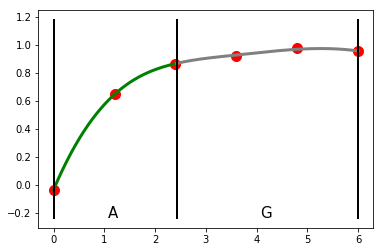

In [26]:
print(x)
print(y)

features(x,y)

In [27]:
x = np.linspace(0,9,10)
y = np.exp(-x) + np.random.random(10)*0

In [28]:
print(x)
print(y)

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[1.00000000e+00 3.67879441e-01 1.35335283e-01 4.97870684e-02
 1.83156389e-02 6.73794700e-03 2.47875218e-03 9.11881966e-04
 3.35462628e-04 1.23409804e-04]


Primitives: ['B', 'G']

Extremes of the primitives: [0.         2.90909091 9.        ]

Value at extremes of the primitives: [9.99986812e-01 5.46968954e-02 1.25779657e-04]

Extrema: [' ', ' ', ' ']



C:\Users\sebas\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(['B', 'G'],
 array([0.        , 2.90909091, 9.        ]),
 array([9.99986812e-01, 5.46968954e-02, 1.25779657e-04]),
 [' ', ' ', ' '])

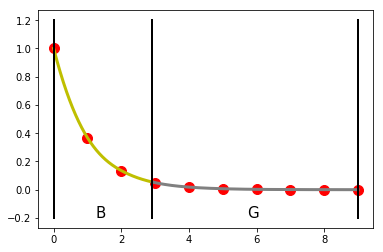

In [30]:
features(x,y)

In [31]:
x = np.linspace(0,9,10)
y = x + np.random.random(10)*1

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[0.63972051 1.2902852  2.45651275 3.90923055 4.35535043 5.76550129
 6.87270485 7.80519665 8.53647785 9.09730736]
Primitives: ['E']

Extremes of the primitives: [0. 9.]

Value at extremes of the primitives: [0.60322083 9.54243666]

Extrema: [' ', ' ']



C:\Users\sebas\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(['E'], array([0., 9.]), array([0.60322083, 9.54243666]), [' ', ' '])

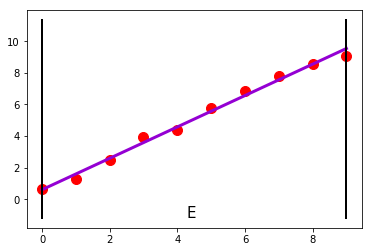

In [32]:
print(x)
print(y)

features(x,y)

In [33]:
x = np.linspace(0,4,5)
y = np.sqrt(x) + np.random.random(5)*1

x = [0. 1. 2. 3. 4.]
y = [0.57665421 1.08233011 1.41894217 2.69003191 2.18867348]

Primitives: ['A', 'G']

Extremes of the primitives: [0.        3.5959596 4.       ]

Value at extremes of the primitives: [0.47075102 2.32026474 2.40344716]

Extrema: [' ', ' ', ' ']



C:\Users\sebas\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(['A', 'G'],
 array([0.       , 3.5959596, 4.       ]),
 array([0.47075102, 2.32026474, 2.40344716]),
 [' ', ' ', ' '])

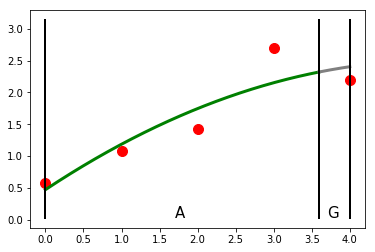

In [34]:
print("x =", x)
print("y =", y)
print()

features(x,y)

In [35]:
x = np.linspace(0,2*np.pi,5)
y = np.sqrt(x) + np.random.random(5) * 1

In [36]:
print(x)
print(y)

[0.         1.57079633 3.14159265 4.71238898 6.28318531]
[0.668203   2.08896279 1.90699887 2.85766289 3.44573855]


Primitives: ['A', 'G', 'C']

Extremes of the primitives: [0.         2.34826118 4.95038842 6.28318531]

Value at extremes of the primitives: [0.24723072 2.28625906 2.4793245  3.3496414 ]

Extrema: [' ', ' ', ' ', ' ']



(['A', 'G', 'C'],
 array([0.        , 2.34826118, 4.95038842, 6.28318531]),
 array([0.24723072, 2.28625906, 2.4793245 , 3.3496414 ]),
 [' ', ' ', ' ', ' '])

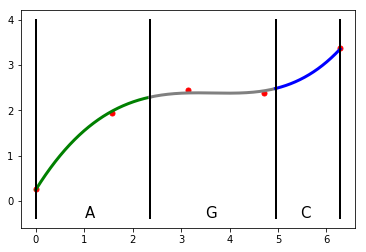

In [36]:
features(x,y)

In [37]:
x = np.linspace(0,4,10)
y = np.square(x) + np.random.random(10) * 2

In [38]:
print(x)
print(y)

[0.         0.44444444 0.88888889 1.33333333 1.77777778 2.22222222
 2.66666667 3.11111111 3.55555556 4.        ]
[ 0.62739747  0.89790547  1.90459139  2.6624665   3.68997839  5.35302783
  8.70530444 10.72172276 13.62183338 17.20321285]


Primitives: ['G', 'C']

Extremes of the primitives: [0.         1.01010101 4.        ]

Value at extremes of the primitives: [ 0.70293005  1.80766435 17.2037842 ]

Extrema: [' ', ' ', ' ']



(['G', 'C'],
 array([0.        , 1.01010101, 4.        ]),
 array([ 0.70293005,  1.80766435, 17.2037842 ]),
 [' ', ' ', ' '])

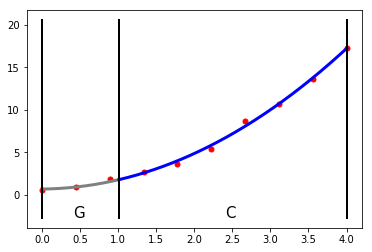

In [39]:
features(x,y)

In [40]:
x = np.linspace(0,2*np.pi,20)
y = np.sqrt(x) + np.random.random(20) * 0.5

Primitives: ['A', 'G']

Extremes of the primitives: [0.         4.5061228  6.28318531]

Value at extremes of the primitives: [0.47727651 2.48230533 2.58597762]

Extrema: [' ', ' ', ' ']



(['A', 'G'],
 array([0.        , 4.5061228 , 6.28318531]),
 array([0.47727651, 2.48230533, 2.58597762]),
 [' ', ' ', ' '])

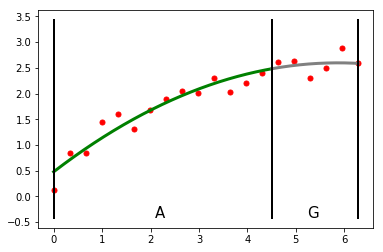

In [41]:
features(x,y)

In [43]:
x = np.linspace(-7,7,8)
y = 1/(1 + np.exp(-x)) + np.random.random(8) * 0.05

[-7. -5. -3. -1.  1.  3.  5.  7.]
[0.0375604  0.02022798 0.06708625 0.28461533 0.76668248 0.95671289
 1.0042834  1.0145141 ]
Primitives: ['G', 'C', 'A', 'G']

Extremes of the primitives: [-7.         -3.32323232  0.07070707  3.32323232  7.        ]

Value at extremes of the primitives: [0.03730789 0.04676906 0.54574092 0.97494717 1.01482141]

Extrema: [' ', ' ', ' ', ' ', ' ']



(['G', 'C', 'A', 'G'],
 array([-7.        , -3.32323232,  0.07070707,  3.32323232,  7.        ]),
 array([0.03730789, 0.04676906, 0.54574092, 0.97494717, 1.01482141]),
 [' ', ' ', ' ', ' ', ' '])

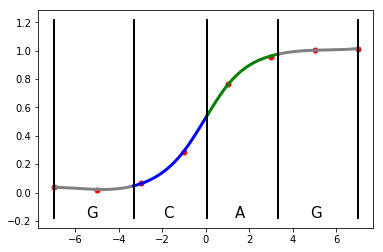

In [44]:
print(x)
print(y)

features(x,y)

In [45]:
x = np.linspace(0,4,10)
y = 2*np.square(x) + np.random.random(10) * 4

Primitives: ['G', 'C']

Extremes of the primitives: [0.         1.13131313 4.        ]

Value at extremes of the primitives: [ 2.78776057  3.8404419  34.47091331]

Extrema: [' ', ' ', ' ']



(['G', 'C'],
 array([0.        , 1.13131313, 4.        ]),
 array([ 2.78776057,  3.8404419 , 34.47091331]),
 [' ', ' ', ' '])

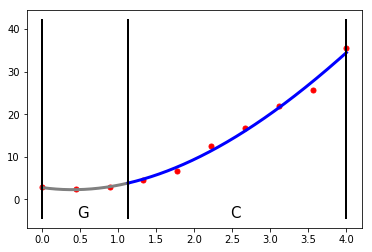

In [46]:
features(x,y)

In [48]:
x = np.linspace(-4,4,6)
y = 2*np.square(x) + np.random.random(6) * 4

In [49]:
print(x)
print(y)

[-4.  -2.4 -0.8  0.8  2.4  4. ]
[33.6754534  12.18265017  1.53933135  2.8189879  13.62972844 33.86562715]


Primitives: ['B', 'C']

Extremes of the primitives: [-4.         -0.12121212  4.        ]

Value at extremes of the primitives: [33.7018235   0.80387054 33.85373043]

Extrema: [' ', 'minimum', ' ']



(['B', 'C'],
 array([-4.        , -0.12121212,  4.        ]),
 array([33.7018235 ,  0.80387054, 33.85373043]),
 [' ', 'minimum', ' '])

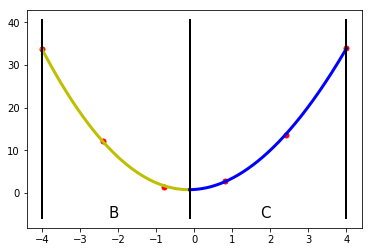

In [50]:
features(x,y)

In [42]:
x = [96.58261214,193.1652243,386.3304486]
y1 = [9.279015583,11.32132471,23.76814889]
y2 = [87.35062266,80.37223832,70.87058821]
y3 = [11.84970838,18.88647211,28.14320319]
y4 = [0.689104903,0.720825327,0.807110087]
y5 = [0.110564058,0.020463973,0.179098508]

lol
Primitives: ['G', 'C']

Extremes of the primitives: [ 96.58261214 204.87220758 386.3304486 ]

Value at extremes of the primitives: [ 9.34760415 11.52948897 23.77851565]

Extrema: [' ', ' ', ' ']



(['G', 'C'],
 array([ 96.58261214, 204.87220758, 386.3304486 ]),
 array([ 9.34760415, 11.52948897, 23.77851565]),
 [' ', ' ', ' '])

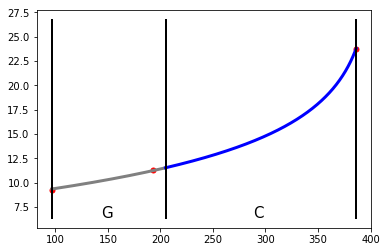

In [43]:
features(x,y1)

Primitives: ['F']

Extremes of the primitives: [ 96.58261214 386.3304486 ]

Value at extremes of the primitives: [86.71417715 70.55236546]

Extrema: [' ', ' ']



(['F'],
 array([ 96.58261214, 386.3304486 ]),
 array([86.71417715, 70.55236546]),
 [' ', ' '])

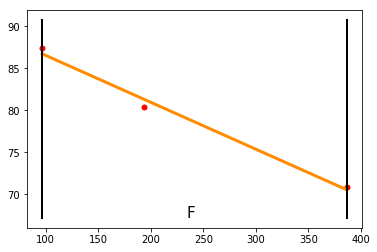

In [44]:
features(x,y2)

Primitives: ['E']

Extremes of the primitives: [ 96.58261214 386.3304486 ]

Value at extremes of the primitives: [12.53782215 28.48726007]

Extrema: [' ', ' ']



(['E'],
 array([ 96.58261214, 386.3304486 ]),
 array([12.53782215, 28.48726007]),
 [' ', ' '])

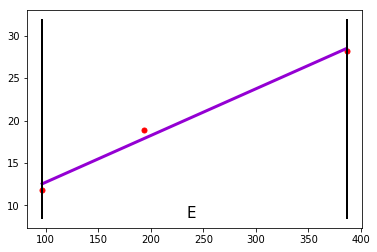

In [45]:
features(x,y3)

Primitives: ['E']

Extremes of the primitives: [ 96.58261214 386.3304486 ]

Value at extremes of the primitives: [0.68584149 0.80547838]

Extrema: [' ', ' ']



(['E'],
 array([ 96.58261214, 386.3304486 ]),
 array([0.68584149, 0.80547838]),
 [' ', ' '])

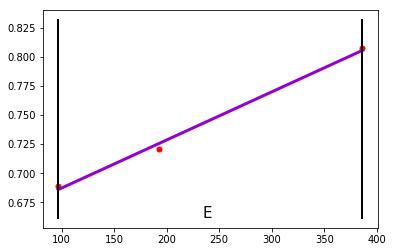

In [54]:
features(x,y4)

Primitives: ['B', 'C']

Extremes of the primitives: [ 96.58261214 222.43268252 386.3304486 ]

Value at extremes of the primitives: [0.11056406 0.0154595  0.17909851]

Extrema: [' ', 'minimum', ' ']



(['B', 'C'],
 array([ 96.58261214, 222.43268252, 386.3304486 ]),
 array([0.11056406, 0.0154595 , 0.17909851]),
 [' ', 'minimum', ' '])

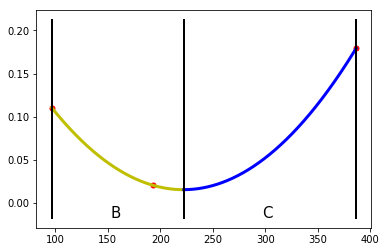

In [55]:
features(x,y5)

In [56]:
x = [548,598,623]
y1 = [5.273462623,22.18593336,35.95604516]
y2 = [86.07235136,72.74037707,65.49826726]
y3 = [13.87206255,26.27784215,33.07811916]
y4 = [0.01063723,0.740846212,1.054819332]
y5 = [0.013914287,0.233557892,0.364242617]

Primitives: ['G', 'C']

Extremes of the primitives: [548.         549.51515152 623.        ]

Value at extremes of the primitives: [ 5.27346262  5.57776578 35.95604516]

Extrema: [' ', ' ', ' ']



(['G', 'C'],
 array([548.        , 549.51515152, 623.        ]),
 array([ 5.27346262,  5.57776578, 35.95604516]),
 [' ', ' ', ' '])

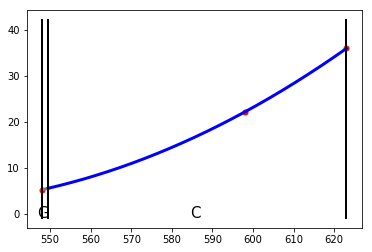

In [57]:
features(x,y1)

Primitives: ['F']

Extremes of the primitives: [548 623]

Value at extremes of the primitives: [86.1546546  65.66287374]

Extrema: [' ', ' ']



(['F'], array([548, 623]), array([86.1546546 , 65.66287374]), [' ', ' '])

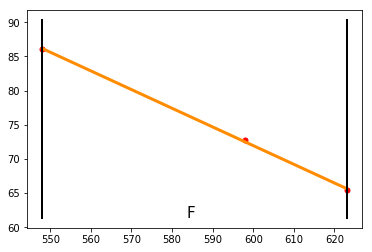

In [58]:
features(x,y2)

Primitives: ['E']

Extremes of the primitives: [548 623]

Value at extremes of the primitives: [13.78672152 32.9074371 ]

Extrema: [' ', ' ']



(['E'], array([548, 623]), array([13.78672152, 32.9074371 ]), [' ', ' '])

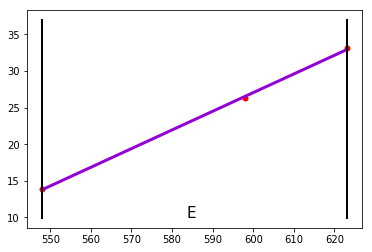

In [59]:
features(x,y3)

Primitives: ['E']

Extremes of the primitives: [548 623]

Value at extremes of the primitives: [0.01794171 1.0694283 ]

Extrema: [' ', ' ']



(['E'], array([548, 623]), array([0.01794171, 1.0694283 ]), [' ', ' '])

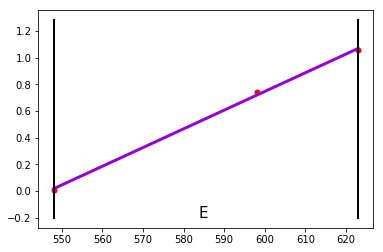

In [60]:
features(x,y4)

Primitives: ['E']

Extremes of the primitives: [548 623]

Value at extremes of the primitives: [0.01093387 0.35828178]

Extrema: [' ', ' ']



(['E'], array([548, 623]), array([0.01093387, 0.35828178]), [' ', ' '])

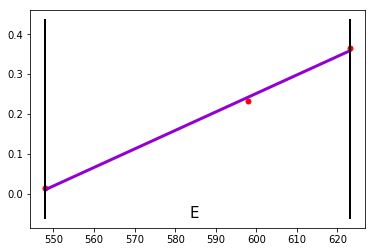

In [61]:
features(x,y5)

In [52]:
x1 = [95.81608347,249.1218171,359.3044234]
x2 = [51.10191118,100.6052411,223.5708615]
y1 = [23.76814889,26.09464349,57.38339297]
y2 = [57.17892445,72.74037707,72.29501013]
y3 = [42.28049668,26.27784215,26.509831]
y4 = [0.342934816,0.740846212,1.004173525]
y5 = [0.197643861,0.233557892,0.190985346]

lol
Primitives: ['G', 'C']

Extremes of the primitives: [ 95.81608347 319.38194765 359.3044234 ]

Value at extremes of the primitives: [23.76815513 28.80355285 57.38339343]

Extrema: [' ', ' ', ' ']



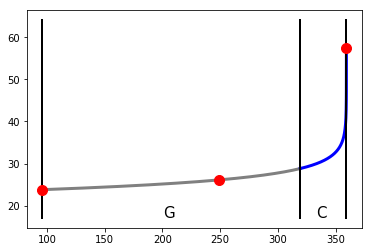

In [57]:
features(x1,y1)
plt.plot(x1, y1, 'ro', ms=10) 

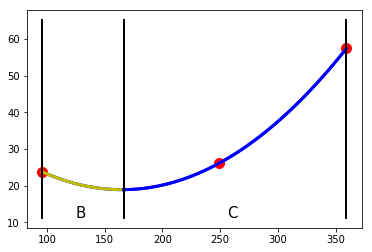

In [56]:
sp = polynomial(x1,y1,2)

m = len(x1)
xs = np.linspace(x1[0],x1[m-1],1000) 

plt.plot(xs, sp(xs), 'b', lw=3)

shape1, shape2, limits = primitives(sp,x1)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x1,y1,sp,limits,p_string)

Primitives: ['A', 'G']

Extremes of the primitives: [ 51.10191118  66.78090666 223.5708615 ]

Value at extremes of the primitives: [57.21505717 71.28937103 72.92543868]

Extrema: [' ', ' ', ' ']



(['A', 'G'],
 array([ 51.10191118,  66.78090666, 223.5708615 ]),
 array([57.21505717, 71.28937103, 72.92543868]),
 [' ', ' ', ' '])

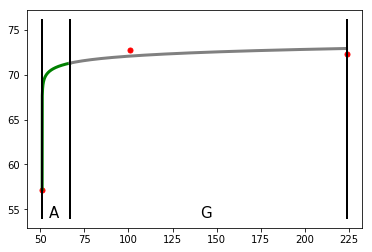

In [64]:
features(x2,y2)

Primitives: ['B', 'G']

Extremes of the primitives: [ 51.10191118  66.78090666 223.5708615 ]

Value at extremes of the primitives: [42.24944615 27.66360454 25.96807438]

Extrema: [' ', ' ', ' ']



(['B', 'G'],
 array([ 51.10191118,  66.78090666, 223.5708615 ]),
 array([42.24944615, 27.66360454, 25.96807438]),
 [' ', ' ', ' '])

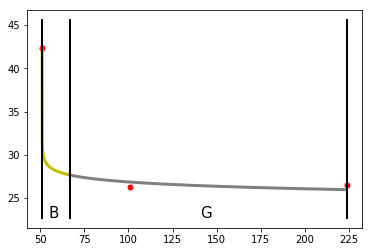

In [65]:
features(x2,y3)

Primitives: ['A', 'G']

Extremes of the primitives: [ 51.10191118 153.88643713 223.5708615 ]

Value at extremes of the primitives: [0.33778145 0.89275972 0.99522642]

Extrema: [' ', ' ', ' ']



(['A', 'G'],
 array([ 51.10191118, 153.88643713, 223.5708615 ]),
 array([0.33778145, 0.89275972, 0.99522642]),
 [' ', ' ', ' '])

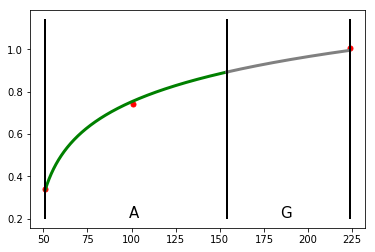

In [66]:
features(x2,y4)

Primitives: ['A', 'D']

Extremes of the primitives: [ 51.10191118 135.59427573 223.5708615 ]

Value at extremes of the primitives: [0.19764386 0.24057184 0.19098535]

Extrema: [' ', 'maximum', ' ']



(['A', 'D'],
 array([ 51.10191118, 135.59427573, 223.5708615 ]),
 array([0.19764386, 0.24057184, 0.19098535]),
 [' ', 'maximum', ' '])

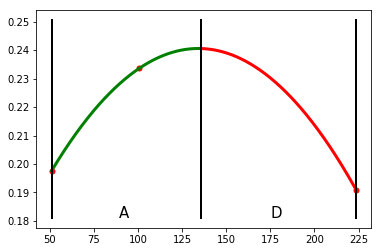

In [67]:
features(x2,y5)

In [68]:
x = [95.81608346793277, 249.12181711286854, 359.30442341124206]
y = [0.17909850773890967, 0.1387942374171868, 0.28431229135140096]

Primitives: ['B', 'C']

Extremes of the primitives: [ 95.81608347 195.62227284 359.30442341]

Value at extremes of the primitives: [0.17909851 0.12076771 0.28431229]

Extrema: [' ', 'minimum', ' ']



(['B', 'C'],
 array([ 95.81608347, 195.62227284, 359.30442341]),
 array([0.17909851, 0.12076771, 0.28431229]),
 [' ', 'minimum', ' '])

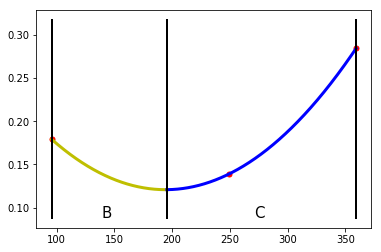

In [69]:
features(x,y)

In [70]:
x = [548, 573, 598, 623]
y = [0.013914287083166626, 0.020463972666510746, 0.23355789194379364, 0.3642426165798604]

Primitives: ['G', 'C']

Extremes of the primitives: [548.         560.12121212 623.        ]

Value at extremes of the primitives: [-0.00053338  0.02291063  0.37869029]

Extrema: [' ', ' ', ' ']



(['G', 'C'],
 array([548.        , 560.12121212, 623.        ]),
 array([-0.00053338,  0.02291063,  0.37869029]),
 [' ', ' ', ' '])

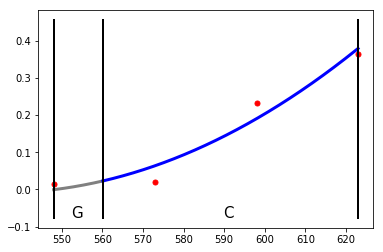

In [71]:
features(x,y)

In [72]:
x = [95.816083, 249.121817, 359.304423]
y = [70.870588, 64.342943, 67.403650 ]

Primitives: ['F']

Extremes of the primitives: [ 95.816083 359.304423]

Value at extremes of the primitives: [69.62428962 65.66957694]

Extrema: [' ', ' ']



(['F'],
 array([ 95.816083, 359.304423]),
 array([69.62428962, 65.66957694]),
 [' ', ' '])

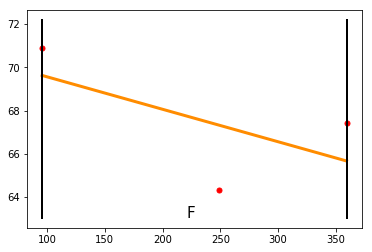

In [73]:
features(x,y)

FOUR CONSIDERED DATASETS

In [74]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [0.36026563, 1.24239091, 2.9502977, 3.26805166, 4.83087873, 5.37428958, 6.45681833, 7.99143781, 8.06068076, 9.1383204]

Primitives: ['E']

Extremes of the primitives: [0 9]

Value at extremes of the primitives: [0.54790861 9.3867777 ]

Extrema: [' ', ' ']



(['E'], array([0, 9]), array([0.54790861, 9.3867777 ]), [' ', ' '])

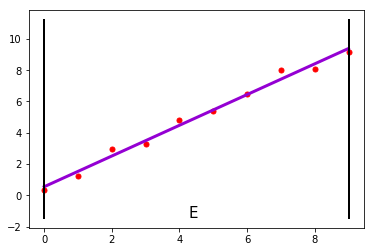

In [75]:
features(x,y)

In [76]:
x = [0, 1, 2, 3, 4]
y = [0.26790572, 1.08639212, 2.31397397, 2.57607642, 2.23173787]

Primitives: ['A', 'D']

Extremes of the primitives: [0.         3.17171717 4.        ]

Value at extremes of the primitives: [0.14158617 2.47739138 2.30852561]

Extrema: [' ', 'maximum', ' ']



(['A', 'D'],
 array([0.        , 3.17171717, 4.        ]),
 array([0.14158617, 2.47739138, 2.30852561]),
 [' ', 'maximum', ' '])

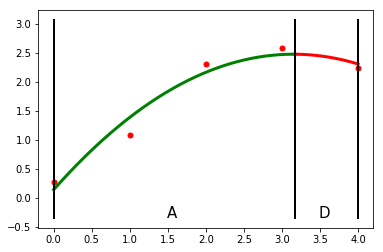

In [77]:
features(x,y)

In [78]:
x = [0, 2, 4, 6, 8, 10]
y = [0.01554831, 0.82824344, 0.94180897, 0.9941693, 0.99203798, 0.99647302]

Primitives: ['A', 'G']

Extremes of the primitives: [ 0.          1.91919192 10.        ]

Value at extremes of the primitives: [0.01321831 0.85844809 1.01143625]

Extrema: [' ', ' ', ' ']



(['A', 'G'],
 array([ 0.        ,  1.91919192, 10.        ]),
 array([0.01321831, 0.85844809, 1.01143625]),
 [' ', ' ', ' '])

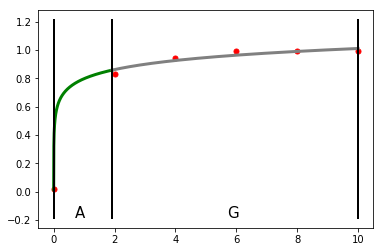

In [79]:
features(x,y)

In [80]:
x = [-7, -5, -3, -1, 1, 3, 5, 7]
y = [0.04791213, 0.05324336, 0.0677637, 0.26345582, 0.6925348, 0.90531751, 0.98343193, 0.97689233]

Primitives: ['G', 'C', 'A', 'G']

Extremes of the primitives: [-7.         -3.04040404  0.07070707  4.03030303  7.        ]

Value at extremes of the primitives: [0.04779445 0.06137738 0.4926507  0.96077174 0.97719425]

Extrema: [' ', ' ', ' ', ' ', ' ']



(['G', 'C', 'A', 'G'],
 array([-7.        , -3.04040404,  0.07070707,  4.03030303,  7.        ]),
 array([0.04779445, 0.06137738, 0.4926507 , 0.96077174, 0.97719425]),
 [' ', ' ', ' ', ' ', ' '])

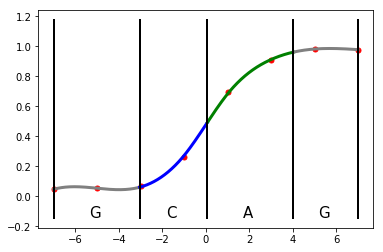

In [81]:
features(x,y)

TEST DATASETS

In [82]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [0.36026563, 1.24239091, 2.9502977, 3.26805166, 4.83087873, 5.37428958, 6.45681833, 7.99143781, 8.06068076, 9.1383204]

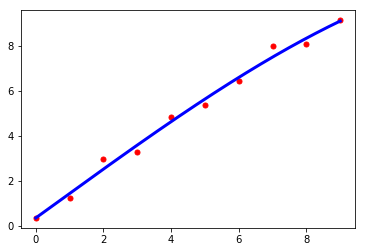

In [83]:
sp = smoothcurve(x,y)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

Primitives: ['E', 'A']

Limits of the primitives: [0, 5.909090909090909, 9]



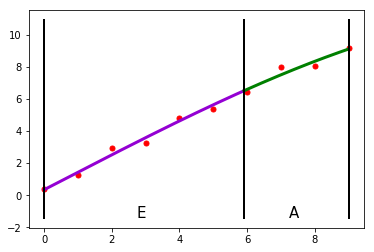

In [84]:
shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)
print("Primitives:", p_string)
print()
    
print("Limits of the primitives:", limits)
print()

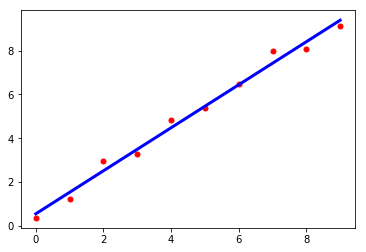

In [85]:
too_complex = primcomplex(p_string)            # Based on the list of strings, it decided whether the curve is too complex or not (see the function 'too_complex' for more information)
sp = simplifysmoothcurve(x,y,sp,too_complex)   # The curve can now be simplified if necessary (see the function 'simplifysmoothcurve' for more information)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

Primitives: ['E']

Extremes of the primitives: [0 9]

Value at extremes of the primitives: [0.54790861 9.3867777 ]

Extrema: [' ', ' ']



(['E'], array([0, 9]), array([0.54790861, 9.3867777 ]), [' ', ' '])

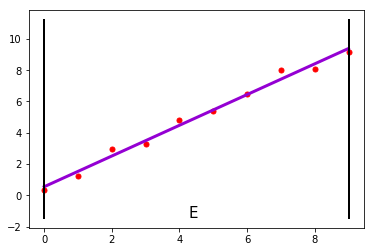

In [86]:
features(x,y)

In [87]:
x = [0, 1, 2, 3, 4]
y = [0.26790572, 1.08639212, 2.31397397, 2.57607642, 2.23173787]

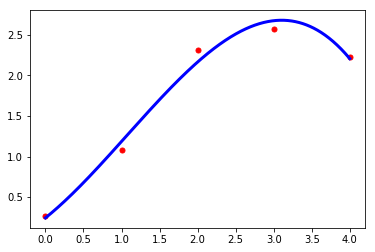

In [88]:
sp = smoothcurve(x,y)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

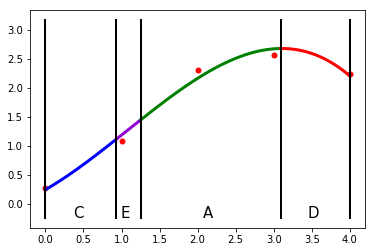

In [89]:
shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)

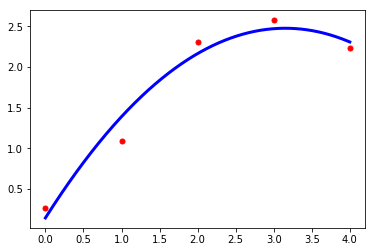

In [90]:
too_complex = primcomplex(p_string)            # Based on the list of strings, it decided whether the curve is too complex or not (see the function 'too_complex' for more information)
sp = simplifysmoothcurve(x,y,sp,too_complex)   # The curve can now be simplified if necessary (see the function 'simplifysmoothcurve' for more information)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

Primitives: ['A', 'D']

Extremes of the primitives: [0.         3.17171717 4.        ]

Value at extremes of the primitives: [0.14158617 2.47739138 2.30852561]

Extrema: [' ', 'maximum', ' ']



(['A', 'D'],
 array([0.        , 3.17171717, 4.        ]),
 array([0.14158617, 2.47739138, 2.30852561]),
 [' ', 'maximum', ' '])

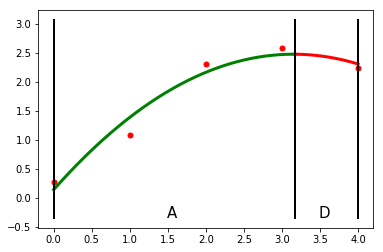

In [91]:
features(x,y)

In [92]:
x = [0, 2, 4, 6, 8, 10]
y = [0.01554831, 0.82824344, 0.94180897, 0.9941693, 0.99203798, 0.99647302]

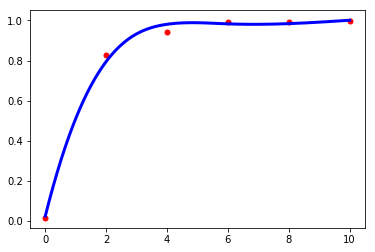

In [93]:
sp = smoothcurve(x,y)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

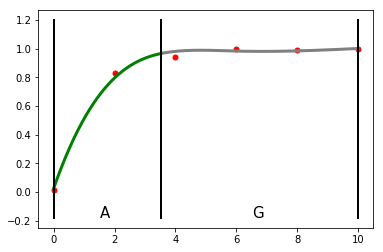

In [94]:
shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)

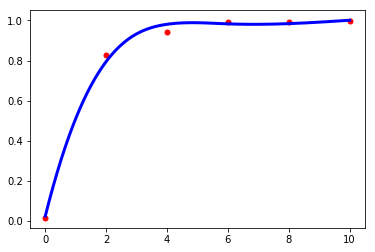

In [95]:
too_complex = primcomplex(p_string)            # Based on the list of strings, it decided whether the curve is too complex or not (see the function 'too_complex' for more information)
sp = simplifysmoothcurve(x,y,sp,too_complex)   # The curve can now be simplified if necessary (see the function 'simplifysmoothcurve' for more information)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

Primitives: ['A', 'G']

Extremes of the primitives: [ 0.          1.91919192 10.        ]

Value at extremes of the primitives: [0.01321831 0.85844809 1.01143625]

Extrema: [' ', ' ', ' ']



(['A', 'G'],
 array([ 0.        ,  1.91919192, 10.        ]),
 array([0.01321831, 0.85844809, 1.01143625]),
 [' ', ' ', ' '])

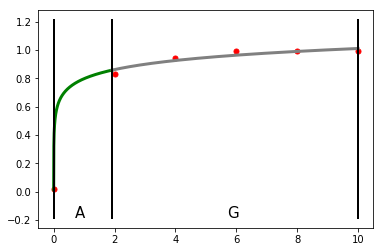

In [96]:
features(x,y)

In [97]:
x = [-7, -5, -3, -1, 1, 3, 5, 7]
y = [0.04791213, 0.05324336, 0.0677637, 0.26345582, 0.6925348, 0.90531751, 0.98343193, 0.97689233]

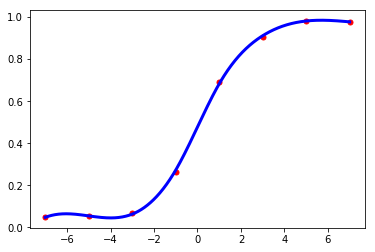

In [98]:
sp = smoothcurve(x,y)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

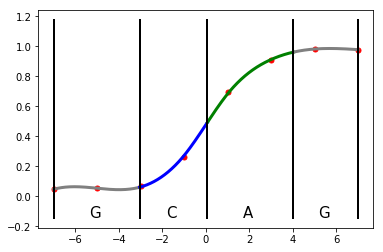

In [99]:
shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)

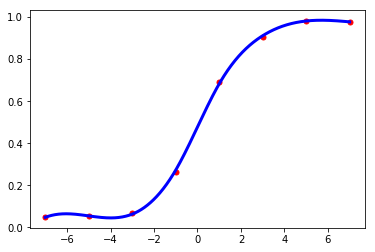

In [100]:
too_complex = primcomplex(p_string)            # Based on the list of strings, it decided whether the curve is too complex or not (see the function 'too_complex' for more information)
sp = simplifysmoothcurve(x,y,sp,too_complex)   # The curve can now be simplified if necessary (see the function 'simplifysmoothcurve' for more information)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

Primitives: ['G', 'C', 'A', 'G']

Extremes of the primitives: [-7.         -3.04040404  0.07070707  4.03030303  7.        ]

Value at extremes of the primitives: [0.04779445 0.06137738 0.4926507  0.96077174 0.97719425]

Extrema: [' ', ' ', ' ', ' ', ' ']



(['G', 'C', 'A', 'G'],
 array([-7.        , -3.04040404,  0.07070707,  4.03030303,  7.        ]),
 array([0.04779445, 0.06137738, 0.4926507 , 0.96077174, 0.97719425]),
 [' ', ' ', ' ', ' ', ' '])

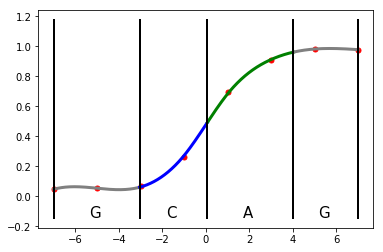

In [101]:
features(x,y)

In [102]:
x = [-5,         -4.8989899,  -4.7979798,  -4.6969697,  -4.5959596,  -4.49494949,
 -4.39393939, -4.29292929, -4.19191919, -4.09090909, -3.98989899, -3.88888889,
 -3.78787879, -3.68686869, -3.58585859, -3.48484848, -3.38383838, -3.28282828,
 -3.18181818, -3.08080808, -2.97979798, -2.87878788, -2.77777778, -2.67676768,
 -2.57575758, -2.47474747, -2.37373737, -2.27272727, -2.17171717, -2.07070707,
 -1.96969697, -1.86868687, -1.76767677, -1.66666667, -1.56565657, -1.46464646,
 -1.36363636, -1.26262626, -1.16161616, -1.06060606, -0.95959596, -0.85858586,
 -0.75757576, -0.65656566, -0.55555556, -0.45454545, -0.35353535, -0.25252525,
 -0.15151515, -0.05050505,  0.05050505,  0.15151515,  0.25252525,  0.35353535,
  0.45454545,  0.55555556,  0.65656566,  0.75757576,  0.85858586,  0.95959596,
  1.06060606,  1.16161616,  1.26262626,  1.36363636,  1.46464646,  1.56565657,
  1.66666667,  1.76767677,  1.86868687,  1.96969697,  2.07070707,  2.17171717,
  2.27272727,  2.37373737,  2.47474747,  2.57575758,  2.67676768,  2.77777778,
  2.87878788,  2.97979798,  3.08080808,  3.18181818,  3.28282828,  3.38383838,
  3.48484848,  3.58585859,  3.68686869,  3.78787879,  3.88888889,  3.98989899,
  4.09090909,  4.19191919,  4.29292929,  4.39393939,  4.49494949,  4.5959596,
  4.6969697,   4.7979798,   4.8989899,   5       ]
y = [0.10405864, 0.04799511, 0.10815544, 0.13381556, 0.04650871, 0.1145704,
 0.09163039, 0.06347563, 0.06691887, 0.12221792, 0.06412388, 0.07170863,
 0.12902176, 0.11821865, 0.08832687, 0.15256649, 0.13227195, 0.16121874,
 0.18700778, 0.16902021, 0.18431507, 0.14572542, 0.19688448, 0.19921751,
 0.20430455, 0.14657967, 0.2420452,  0.2358009,  0.2167907,  0.2579243,
 0.23383467, 0.28560685, 0.34148491, 0.31507443, 0.34241469, 0.33756531,
 0.38263572, 0.43709409, 0.48777945, 0.54310311, 0.52542079, 0.63033782,
 0.6394712,  0.79090498, 0.85384184, 0.84191888, 0.93641928, 0.98129386,
 1.0355247,  1.01599033, 1.04426606, 0.99490611, 0.97565669, 0.93119473,
 0.85697403, 0.8289701,  0.73925233, 0.64236041, 0.60328395, 0.59747125,
 0.55206691, 0.49727948, 0.44246235, 0.40557046, 0.39320448, 0.33052866,
 0.34017636, 0.25500516, 0.27276036, 0.25900296, 0.20034687, 0.25131238,
 0.16719261, 0.17434897, 0.20083498, 0.13227929, 0.15275999, 0.21348247,
 0.15867921, 0.17271027, 0.11629032, 0.15217738, 0.14626543, 0.13947515,
 0.11060244, 0.13958649, 0.06891078, 0.07280089, 0.13370183, 0.07636459,
 0.14482874, 0.1467442,  0.05524048, 0.07469021, 0.06916272, 0.05569129,
 0.04494795, 0.11327818, 0.11755076, 0.0993147 ]

[-5.  5.]


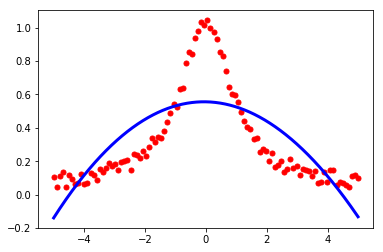

In [103]:
sp = smoothcurve(x,y)
print(sp.get_knots())

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

Primitives: ['A', 'G']

Extremes of the primitives: [0.         4.82345539 6.28318531]

Value at extremes of the primitives: [0.58284111 2.48314449 2.6079449 ]

Extrema: [' ', ' ', ' ']



(['A', 'G'],
 array([0.        , 4.82345539, 6.28318531]),
 array([0.58284111, 2.48314449, 2.6079449 ]),
 [' ', ' ', ' '])

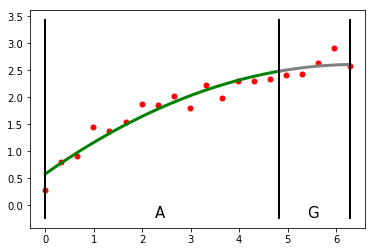

In [104]:
x = np.linspace(0,2*np.pi,20)
y = np.sqrt(x) + np.random.random(20) * 0.5
features(x,y)

Primitives: ['E']

Extremes of the primitives: [0.  1.5]

Value at extremes of the primitives: [1.27478517 4.60737967]

Extrema: [' ', ' ']



(['E'], array([0. , 1.5]), array([1.27478517, 4.60737967]), [' ', ' '])

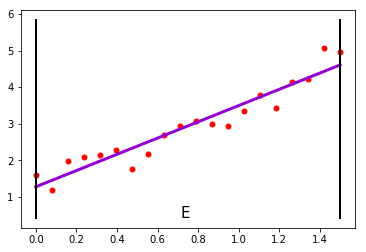

In [105]:
x = np.linspace(0,1.5,20)
y = np.exp(x) + np.random.random(20) * 1
features(x,y)

Primitives: ['A', 'E', 'G']

Extremes of the primitives: [0.         5.39465405 5.58505361 6.28318531]

Value at extremes of the primitives: [0.18257563 2.83286049 2.87636797 3.02597777]

Extrema: [' ', ' ', ' ', ' ']



(['A', 'E', 'G'],
 array([0.        , 5.39465405, 5.58505361, 6.28318531]),
 array([0.18257563, 2.83286049, 2.87636797, 3.02597777]),
 [' ', ' ', ' ', ' '])

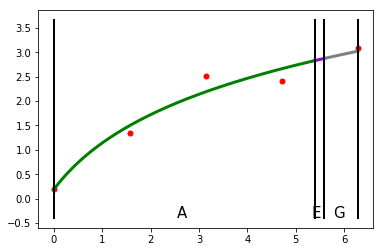

In [106]:
x = np.linspace(0,2*np.pi,5)
y = np.sqrt(x) + np.random.random(5) * 1
features(x,y)

Primitives: ['G', 'C']

Extremes of the primitives: [0.         1.24242424 3.        ]

Value at extremes of the primitives: [-2.12761840e-16  1.91782842e+00  2.70000000e+01]

Extrema: [' ', ' ', ' ']



(['G', 'C'],
 array([0.        , 1.24242424, 3.        ]),
 array([-2.12761840e-16,  1.91782842e+00,  2.70000000e+01]),
 [' ', ' ', ' '])

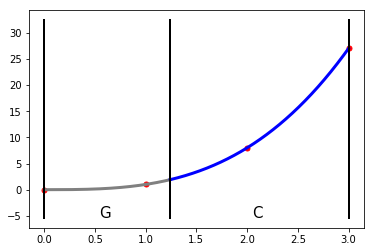

In [107]:
x = np.linspace(0,3,4)
y = np.power(x,3)
features(x,y)

Primitives: ['G', 'D']

Extremes of the primitives: [0.         0.24242424 1.        ]

Value at extremes of the primitives: [1.06691472 1.04212065 0.09779883]

Extrema: [' ', ' ', ' ']



(['G', 'D'],
 array([0.        , 0.24242424, 1.        ]),
 array([1.06691472, 1.04212065, 0.09779883]),
 [' ', ' ', ' '])

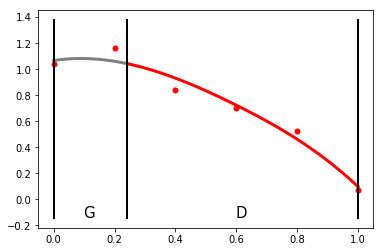

In [46]:
x = np.linspace(0,1,6)
y = 1 - np.square(x) + np.random.random(6) * 0.2
features(x,y)

In [109]:
print(x)
print(y)

[0.  0.2 0.4 0.6 0.8 1. ]
[1.03316243 1.12628897 0.89452765 0.75700063 0.49968767 0.09227884]


Primitives: ['G', 'C', 'A', 'G']

Extremes of the primitives: [-10.          -3.53535354   0.1010101    3.73737374  10.        ]

Value at extremes of the primitives: [0.02095839 0.02946132 0.53834303 1.00095639 1.00905836]

Extrema: [' ', ' ', ' ', ' ', ' ']



(['G', 'C', 'A', 'G'],
 array([-10.        ,  -3.53535354,   0.1010101 ,   3.73737374,
         10.        ]),
 array([0.02095839, 0.02946132, 0.53834303, 1.00095639, 1.00905836]),
 [' ', ' ', ' ', ' ', ' '])

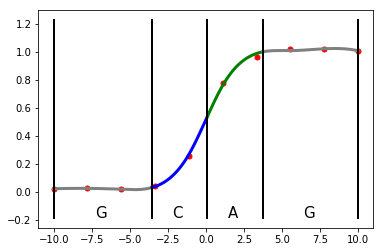

In [110]:
x = np.linspace(-10,10,10)
y = 1/(1 + np.exp(-x)) + np.random.random(10)*0.03
features(x,y)

In [111]:
print(x)
print(y)

[-10.          -7.77777778  -5.55555556  -3.33333333  -1.11111111
   1.11111111   3.33333333   5.55555556   7.77777778  10.        ]
[0.02096944 0.02327107 0.01572213 0.04057158 0.2560965  0.78056866
 0.96723228 1.02411066 1.01812844 1.0096146 ]


Primitives: ['B', 'C']

Extremes of the primitives: [-2.          0.02020202  2.        ]

Value at extremes of the primitives: [4.3332706  0.19875565 4.27455704]

Extrema: [' ', 'minimum', ' ']



(['B', 'C'],
 array([-2.        ,  0.02020202,  2.        ]),
 array([4.3332706 , 0.19875565, 4.27455704]),
 [' ', 'minimum', ' '])

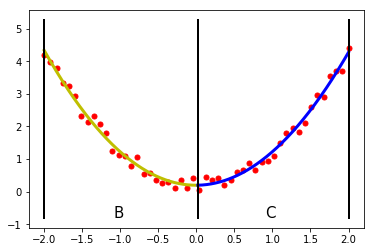

In [112]:
x = np.linspace(-2,2,50)
y = np.square(x) + np.random.random(50) * 0.5
features(x,y)

In [113]:
print(x)
print(y)

[-2.         -1.91836735 -1.83673469 -1.75510204 -1.67346939 -1.59183673
 -1.51020408 -1.42857143 -1.34693878 -1.26530612 -1.18367347 -1.10204082
 -1.02040816 -0.93877551 -0.85714286 -0.7755102  -0.69387755 -0.6122449
 -0.53061224 -0.44897959 -0.36734694 -0.28571429 -0.20408163 -0.12244898
 -0.04081633  0.04081633  0.12244898  0.20408163  0.28571429  0.36734694
  0.44897959  0.53061224  0.6122449   0.69387755  0.7755102   0.85714286
  0.93877551  1.02040816  1.10204082  1.18367347  1.26530612  1.34693878
  1.42857143  1.51020408  1.59183673  1.67346939  1.75510204  1.83673469
  1.91836735  2.        ]
[4.20364511 3.9676897  3.78136561 3.33835395 3.24701155 2.93344656
 2.31487892 2.14399041 2.31335912 2.07946722 1.80484378 1.24348456
 1.11084326 1.09574116 0.80073087 1.0611202  0.53323104 0.57376299
 0.36909232 0.25275982 0.2936615  0.1094487  0.36245224 0.12630599
 0.42672174 0.06184789 0.4502576  0.3600325  0.4282685  0.2140691
 0.35911303 0.606496   0.66358219 0.87892078 0.67911541 0

Primitives: ['F']

Extremes of the primitives: [0.         6.28318531]

Value at extremes of the primitives: [1.09984083 0.5056531 ]

Extrema: [' ', ' ']



(['F'],
 array([0.        , 6.28318531]),
 array([1.09984083, 0.5056531 ]),
 [' ', ' '])

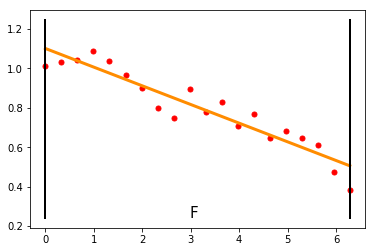

In [114]:
x = np.linspace(0,2*np.pi,20)
y = 1- 0.1*x + np.random.random(20) * 0.2
features(x,y)

In [115]:
print(x)
print(y)

[0.         0.33069396 0.66138793 0.99208189 1.32277585 1.65346982
 1.98416378 2.31485774 2.64555171 2.97624567 3.30693964 3.6376336
 3.96832756 4.29902153 4.62971549 4.96040945 5.29110342 5.62179738
 5.95249134 6.28318531]
[1.01328716 1.02950336 1.04187403 1.08889152 1.03658431 0.96631774
 0.8999079  0.79962556 0.7499352  0.89582034 0.77917561 0.83075328
 0.7060489  0.76688681 0.64862402 0.68437207 0.64660667 0.61312439
 0.47289523 0.38470526]


In [116]:
x = [0, 0.037, 0.12, 0.221, 0.343, 0.543]
y = [0, 15.83, 24.54, 23.97, 26.68, 27.12]

3


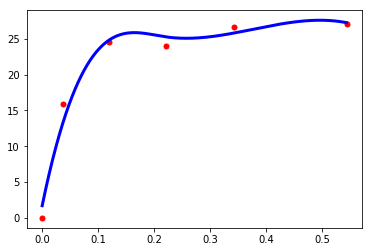

In [117]:
m = len(x)
sp = smoothcurve(x,y)
print(len(sp.get_knots()))

xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

4


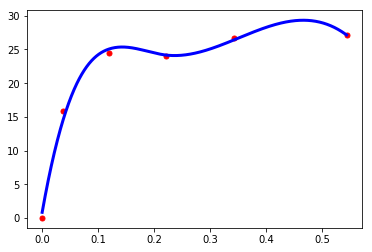

In [118]:
m = len(x)
sp = UnivariateSpline(x,y,None,[None,None],3,m/2)
print(len(sp.get_knots()))

xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

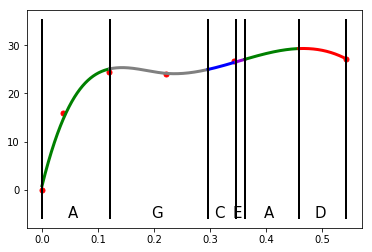

In [119]:
shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)

In [120]:
for i in range(6-1,-1, -1):
    print(i)

5
4
3
2
1
0


In [121]:
x = np.linspace(0,9,10)
y = np.exp(-x) + np.random.random(10)*0

7


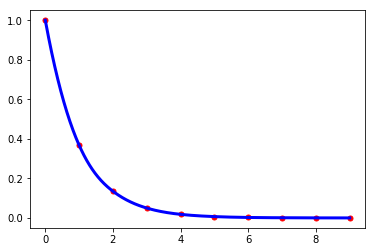

In [122]:
m = len(x)
sp = UnivariateSpline(x,y,None,[None,None],3,m/33554432/2)
print(len(sp.get_knots()))

xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

Primitives: ['B', 'G']

Extremes of the primitives: [0.         2.90909091 9.        ]

Value at extremes of the primitives: [9.99986812e-01 5.46968954e-02 1.25779657e-04]

Extrema: [' ', ' ', ' ']



(['B', 'G'],
 array([0.        , 2.90909091, 9.        ]),
 array([9.99986812e-01, 5.46968954e-02, 1.25779657e-04]),
 [' ', ' ', ' '])

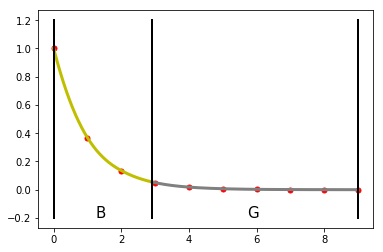

In [123]:
features(x,y)

In [124]:
x = [0, 0.037, 0.12, 0.221, 0.343, 0.543]
y = [0, 15.83, 24.54, 23.97, 26.68, 27.12]

Primitives: ['A', 'G']

Extremes of the primitives: [0.         0.14809091 0.543     ]

Value at extremes of the primitives: [-0.28338828 22.98600334 27.78290634]

Extrema: [' ', ' ', ' ']



Text(0, 0.5, 'X(Phenol) [mol%]')

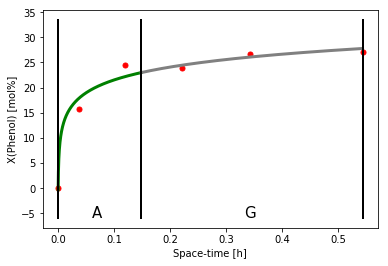

In [125]:
features(x,y)
plt.xlabel("Space-time [h]")     
plt.ylabel("X(Phenol) [mol%]")  

In [126]:
x = [15.83, 23.97, 24.54, 26.68, 27.12]
y = [91.02969046, 83.41483293, 74.63496037, 71.2143928, 61.54129794]

Primitives: ['G', 'D']

Extremes of the primitives: [15.83       21.07585859 27.12      ]

Value at extremes of the primitives: [90.38728293 85.61680993 62.32816338]

Extrema: [' ', ' ', ' ']



Text(0, 0.5, 'S(Cyclohexanone) [mol%]')

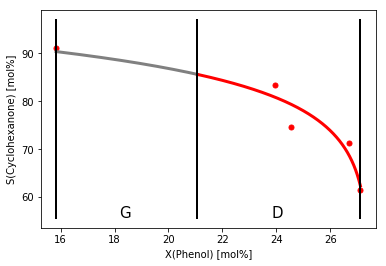

In [127]:
features(x,y)
plt.xlabel("X(Phenol) [mol%]")  
plt.ylabel("S(Cyclohexanone) [mol%]")  

In [128]:
x = [15.83, 23.97, 24.54, 26.68, 27.12]
y = [5.93809223, 13.81418093, 14.85189821, 17.87856072, 19.21091445]

Primitives: ['E']

Extremes of the primitives: [15.83 27.12]

Value at extremes of the primitives: [ 5.57164958 18.26469012]

Extrema: [' ', ' ']



Text(0, 0.5, 'S(Cyclohexanol) [mol%]')

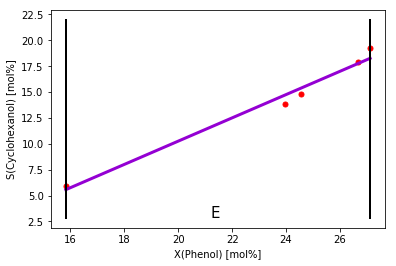

In [129]:
features(x,y)
plt.xlabel("X(Phenol) [mol%]")  
plt.ylabel("S(Cyclohexanol) [mol%]")  

In [130]:
x = [15.83, 23.97, 24.54, 26.68, 27.12]
y = [0, 3.382233089, 9.303295786, 10.4197901, 18.84218289]

2


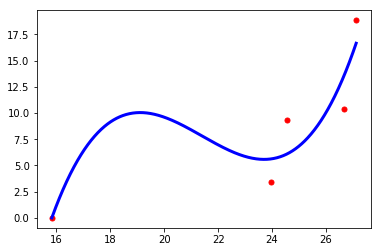

In [131]:
m = len(x)
sp = UnivariateSpline(x,y,None,[None,None],3,m*500)
print(len(sp.get_knots()))

xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

Primitives: ['G', 'C']

Extremes of the primitives: [15.83       21.76010101 27.12      ]

Value at extremes of the primitives: [-0.05892438  3.16256203 17.67201822]

Extrema: [' ', ' ', ' ']



Text(0, 0.5, 'S(Benzene) [mol%]')

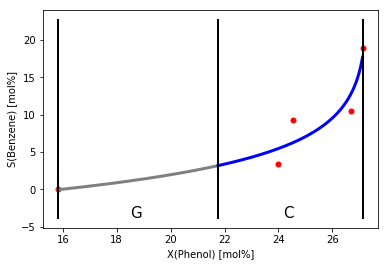

In [132]:
features(x,y)
plt.xlabel("X(Phenol) [mol%]")  
plt.ylabel("S(Benzene) [mol%]")  

In [133]:
x = [0, 0.0069, 0.0106, 0.0187, 0.0214, 0.0364, 0.0428, 0.053]
y = [0, 5.49, 6.63, 15.06, 18.57, 35.33, 44.61, 56.27]

Primitives: ['E']

Extremes of the primitives: [0.    0.053]

Value at extremes of the primitives: [-3.10212685 54.63855694]

Extrema: [' ', ' ']



Text(0, 0.5, 'X(Phenol) [mol%]')

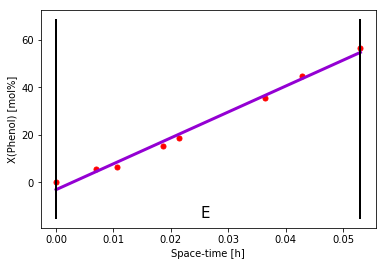

In [134]:
features(x,y)
plt.xlabel("Space-time [h]")     
plt.ylabel("X(Phenol) [mol%]")  

In [135]:
x = [5.49, 6.63, 15.06, 18.57, 35.33, 44.61, 56.27]
y = [62.1129326, 72.85067873, 65.40504648, 81.09854604, 73.98811209, 72.20354181, 74.74675671]

Primitives: ['E']

Extremes of the primitives: [ 5.49 56.27]

Value at extremes of the primitives: [69.15374552 75.63856904]

Extrema: [' ', ' ']



Text(0, 0.5, 'S(Benzene) [mol%]')

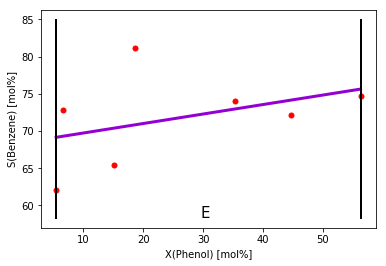

In [136]:
features(x,y)
plt.xlabel("X(Phenol) [mol%]")  
plt.ylabel("S(Benzene) [mol%]")  

In [137]:
x = [5.49, 6.63, 15.06, 18.57, 35.33, 44.61, 56.27]
y = [17.30418944, 17.19457014, 11.95219124, 12.22401723, 6.708180017, 2.757229321, 4.549493513]

Primitives: ['B', 'G']

Extremes of the primitives: [ 5.49       42.42090909 56.27      ]

Value at extremes of the primitives: [17.62738978  4.63822495  3.91671269]

Extrema: [' ', ' ', ' ']



Text(0, 0.5, 'S(Cyclohexanone) [mol%]')

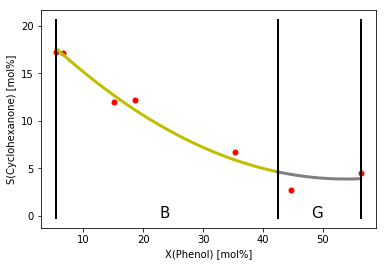

In [138]:
features(x,y)
plt.xlabel("X(Phenol) [mol%]")  
plt.ylabel("S(Cyclohexanone) [mol%]")  

In [139]:
x = [5.49, 6.63, 15.06, 18.57, 35.33, 44.61, 56.27]
y = [0, 0, 1.859229748, 2.046311255, 5.349561279, 4.46088321, 9.098987027]

2


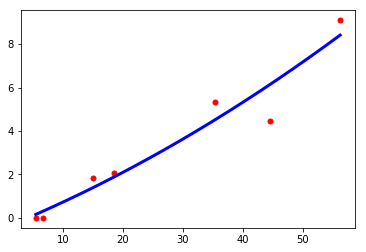

In [140]:
m = len(x)
sp = UnivariateSpline(x,y,None,[None,None],2,m)
print(len(sp.get_knots()))

xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

Primitives: ['A', 'E', 'C']

Extremes of the primitives: [ 5.49       26.52010101 31.13646465 56.27      ]

Value at extremes of the primitives: [-0.24454115  3.33234025  3.75416109  8.84763513]

Extrema: [' ', ' ', ' ', ' ']



C:\Users\sebas\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\sebas\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars


Text(0, 0.5, 'S(Biphenyl) [mol%]')

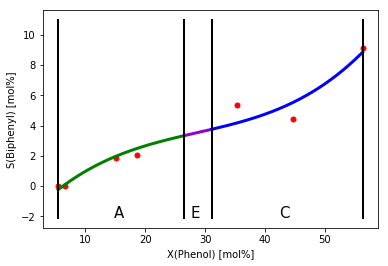

In [141]:
features(x,y)
plt.xlabel("X(Phenol) [mol%]")  
plt.ylabel("S(Biphenyl) [mol%]")  

In [142]:
x = [5.49, 6.63, 15.06, 18.57, 35.33, 44.61, 56.27]
y = [0, 0, 0, 1.507808293, 1.330314181, 2.331315848, 1.350630887]

Primitives: ['A', 'D']

Extremes of the primitives: [ 5.49       43.19030303 56.27      ]

Value at extremes of the primitives: [-0.16092571  1.79375051  1.55104587]

Extrema: [' ', 'maximum', ' ']



C:\Users\sebas\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\sebas\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars


Text(0, 0.5, 'S(Cyclohexane) [mol%]')

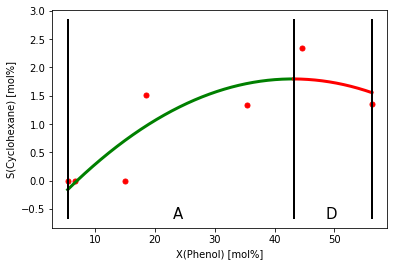

In [143]:
features(x,y)
plt.xlabel("X(Phenol) [mol%]")  
plt.ylabel("S(Cyclohexane) [mol%]")  

In [144]:
x = np.linspace(0,9,10)
list_x = [x, x]
list_y = [x + np.random.random(10)*1, x + np.random.random(10)*1]

DATASET 1
-----------

Primitives: ['E']

Extremes of the primitives: [0.0, 9.0]

Value at extremes of the primitives of: [0.54351094 9.82804935]


DATASET 2
-----------

Primitives: ['E']

Extremes of the primitives: [0.0, 9.0]

Value at extremes of the primitives of: [0.61861081 9.4291904 ]




([['E'], ['E']],
 [[0.0, 9.0], [0.0, 9.0]],
 [array([0.54351094, 9.82804935]), array([0.61861081, 9.4291904 ])],
 [[' ', ' '], [' ', ' ']])

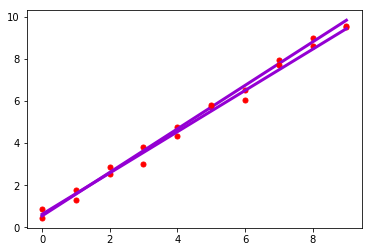

In [145]:
features_parametric(list_x, list_y)

In [146]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [0.36026563, 1.24239091, 2.9502977, 3.26805166, 4.83087873, 5.37428958, 6.45681833, 7.99143781, 8.06068076, 9.1383204]

Primitives: ['E']

Extremes of the primitives: [0 9]

Value at extremes of the primitives: [0.54790861 9.3867777 ]

Extrema: [' ', ' ']



(['E'], array([0, 9]), array([0.54790861, 9.3867777 ]), [' ', ' '])

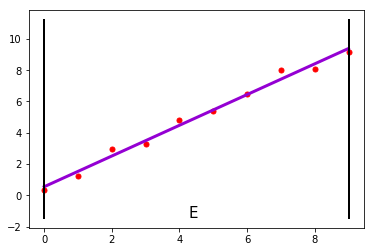

In [147]:
features(x,y)

In [148]:
x = [0, 1, 2, 3, 4]
y = [0.26790572, 1.08639212, 2.31397397, 2.57607642, 2.23173787]

Primitives: ['A', 'D']

Extremes of the primitives: [0.         3.17171717 4.        ]

Value at extremes of the primitives: [0.14158617 2.47739138 2.30852561]

Extrema: [' ', 'maximum', ' ']



(['A', 'D'],
 array([0.        , 3.17171717, 4.        ]),
 array([0.14158617, 2.47739138, 2.30852561]),
 [' ', 'maximum', ' '])

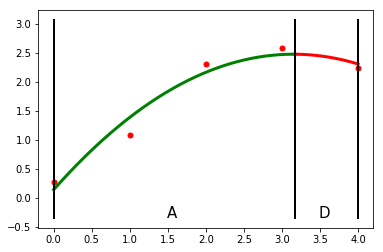

In [149]:
features(x,y)

In [150]:
x = [0, 2, 4, 6, 8, 10]
y = [0.01554831, 0.82824344, 0.94180897, 0.9941693, 0.99203798, 0.99647302]

Primitives: ['A', 'G']

Extremes of the primitives: [ 0.          1.91919192 10.        ]

Value at extremes of the primitives: [0.01321831 0.85844809 1.01143625]

Extrema: [' ', ' ', ' ']



(['A', 'G'],
 array([ 0.        ,  1.91919192, 10.        ]),
 array([0.01321831, 0.85844809, 1.01143625]),
 [' ', ' ', ' '])

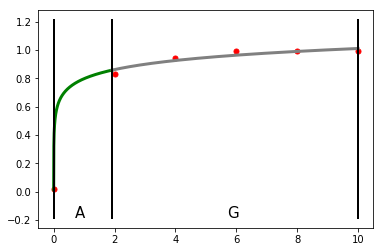

In [151]:
features(x,y)

In [152]:
x = [-7, -5, -3, -1, 1, 3, 5, 7]
y = [0.04791213, 0.05324336, 0.0677637, 0.26345582, 0.6925348, 0.90531751, 0.98343193, 0.97689233]

Primitives: ['G', 'C', 'A', 'G']

Extremes of the primitives: [-7.         -3.04040404  0.07070707  4.03030303  7.        ]

Value at extremes of the primitives: [0.04779445 0.06137738 0.4926507  0.96077174 0.97719425]

Extrema: [' ', ' ', ' ', ' ', ' ']



(['G', 'C', 'A', 'G'],
 array([-7.        , -3.04040404,  0.07070707,  4.03030303,  7.        ]),
 array([0.04779445, 0.06137738, 0.4926507 , 0.96077174, 0.97719425]),
 [' ', ' ', ' ', ' ', ' '])

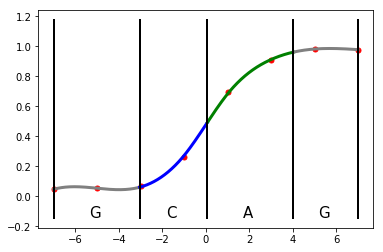

In [153]:
features(x,y)

In [154]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [1.00000000e+00, 3.67879441e-01, 1.35335283e-01, 4.97870684e-02,
1.83156389e-02, 6.73794700e-03, 2.47875218e-03, 9.11881966e-04,
3.35462628e-04, 1.23409804e-04]

Primitives: ['B', 'G']

Extremes of the primitives: [0.         2.90909091 9.        ]

Value at extremes of the primitives: [9.99986812e-01 5.46968955e-02 1.25779656e-04]

Extrema: [' ', ' ', ' ']



(['B', 'G'],
 array([0.        , 2.90909091, 9.        ]),
 array([9.99986812e-01, 5.46968955e-02, 1.25779656e-04]),
 [' ', ' ', ' '])

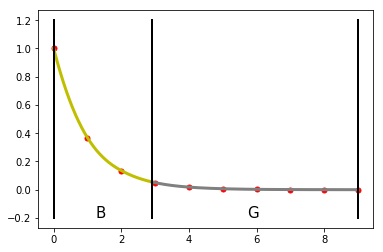

In [155]:
features(x,y)

In [53]:
x = [0,         1.5707963, 3.14159265, 4.71238898, 6.28318531]
x = [x[4]-x[4],x[4]-x[3],x[4]-x[2],x[4]-x[1],x[4]-x[0]]
y = [0.47276355, 1.90286246, 2.26235211, 2.79725421, 3.1762962 ]
y = [y[4],y[3],y[2],y[1],y[0]]

lol
Primitives: ['G', 'D']

Extremes of the primitives: [0.         1.45972992 6.28318531]

Value at extremes of the primitives: [3.10319676 2.83198324 0.47844303]

Extrema: [' ', ' ', ' ']



(['G', 'D'],
 array([0.        , 1.45972992, 6.28318531]),
 array([3.10319676, 2.83198324, 0.47844303]),
 [' ', ' ', ' '])

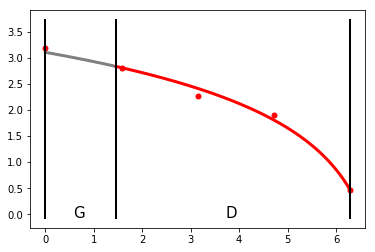

In [54]:
features(x,y)

In [158]:
x = [0,         0.44444444, 0.88888889, 1.33333333, 1.77777778, 2.22222222,
 2.66666667, 3.11111111, 3.55555556, 4        ]
y = [ 0.98493316,  0.9710389,   2.41039582,  2.20679543,  3.91351111,  5.81136207,
  7.8736791,  10.77637367, 13.69523694, 16.51376138]

Primitives: ['G', 'C']

Extremes of the primitives: [0.         1.01010101 4.        ]

Value at extremes of the primitives: [ 1.06631634  1.88719872 16.69210418]

Extrema: [' ', ' ', ' ']



(['G', 'C'],
 array([0.        , 1.01010101, 4.        ]),
 array([ 1.06631634,  1.88719872, 16.69210418]),
 [' ', ' ', ' '])

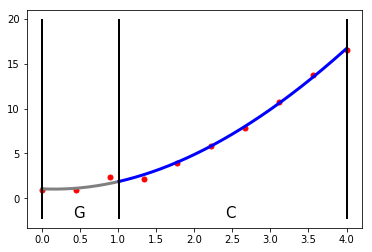

In [159]:
features(x,y)

In [160]:
x = [-4,         -3.11111111, -2.22222222, -1.33333333, -0.44444444,  0.44444444,
  1.33333333,  2.22222222,  3.11111111,  4        ]
y = [34.29800306, 21.12049583, 10.33274444,  5.73778232,  4.08119098,  3.29860923,
  4.18743004, 12.62199902, 21.13386542, 32.22028368]

Primitives: ['B', 'C']

Extremes of the primitives: [-4.          0.08080808  4.        ]

Value at extremes of the primitives: [34.45759003  2.75970504 32.26583515]

Extrema: [' ', 'minimum', ' ']



(['B', 'C'],
 array([-4.        ,  0.08080808,  4.        ]),
 array([34.45759003,  2.75970504, 32.26583515]),
 [' ', 'minimum', ' '])

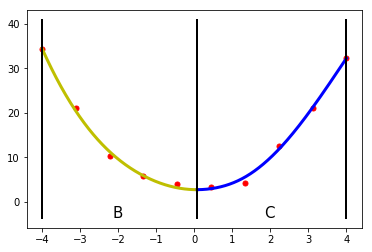

In [161]:
features(x,y)

In [34]:
x = [0,  0.2, 0.4, 0.6, 0.8, 1 ]
y = [1.11112913, 1.06759245, 1.00020118, 0.78271128, 0.54475117, 0.15034238]

Primitives: ['G', 'D']

Extremes of the primitives: [0.         0.31313131 1.        ]

Value at extremes of the primitives: [1.10947919 1.03374149 0.15210185]

Extrema: [' ', ' ', ' ']



(['G', 'D'],
 array([0.        , 0.31313131, 1.        ]),
 array([1.10947919, 1.03374149, 0.15210185]),
 [' ', ' ', ' '])

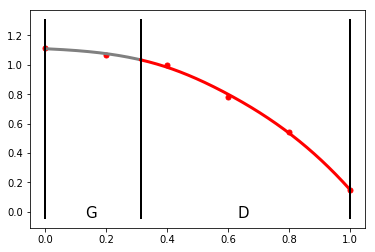

In [35]:
features(x,y)

In [164]:
x = [-10,          -7.77777778,  -5.55555556,  -3.33333333,  -1.11111111,
   1.11111111,   3.33333333,   5.55555556,   7.77777778,  10       ]
y = [0.01233659, 0.02285638, 0.01756967, 0.05102681, 0.25942577, 0.75735877,
 0.97962353, 1.000331,   1.01648697, 1.02812304]

Primitives: ['G', 'C', 'A', 'G']

Extremes of the primitives: [-10.          -3.73737374   0.1010101    3.73737374  10.        ]

Value at extremes of the primitives: [0.01234646 0.03712044 0.5303886  0.99281677 1.02809781]

Extrema: [' ', ' ', ' ', ' ', ' ']



(['G', 'C', 'A', 'G'],
 array([-10.        ,  -3.73737374,   0.1010101 ,   3.73737374,
         10.        ]),
 array([0.01234646, 0.03712044, 0.5303886 , 0.99281677, 1.02809781]),
 [' ', ' ', ' ', ' ', ' '])

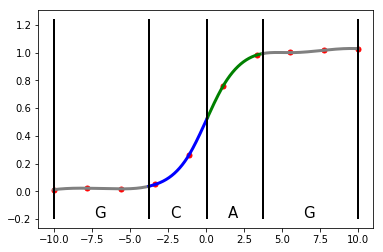

In [165]:
features(x,y)

In [166]:
x = [-2,         -1.91836735, -1.83673469, -1.75510204, -1.67346939, -1.59183673,
 -1.51020408, -1.42857143, -1.34693878, -1.26530612, -1.18367347, -1.10204082,
 -1.02040816, -0.93877551, -0.85714286, -0.7755102,  -0.69387755, -0.6122449,
 -0.53061224, -0.44897959, -0.36734694, -0.28571429, -0.20408163, -0.12244898,
 -0.04081633,  0.04081633,  0.12244898,  0.20408163,  0.28571429,  0.36734694,
  0.44897959,  0.53061224,  0.6122449,   0.69387755,  0.7755102,   0.85714286,
  0.93877551,  1.02040816,  1.10204082,  1.18367347,  1.26530612,  1.34693878,
  1.42857143,  1.51020408,  1.59183673,  1.67346939,  1.75510204,  1.83673469,
  1.91836735,  2        ]
y = [4.38918807, 3.77021945, 3.5697983,  3.30301791, 3.14406834, 2.93059296,
 2.39064185, 2.17599725, 2.18675213, 1.61019229, 1.50205171, 1.66301126,
 1.25242059, 1.1634721,  0.82026007, 0.70013101, 0.63604271, 0.84344811,
 0.33044497, 0.66658561, 0.46869503, 0.25323949, 0.41513815, 0.47100867,
 0.01825418, 0.0082534,  0.07831117, 0.1284713,  0.39219081, 0.44721517,
 0.29688915, 0.42579862, 0.86853603, 0.50360682, 0.65272888, 1.04553224,
 0.96322578, 1.23233739, 1.33098975, 1.44228588, 1.7808976,  1.84415977,
 2.37641459, 2.57774678, 2.73911046, 3.1584753,  3.27409043, 3.40364342,
 3.79311352, 4.11565155]

Primitives: ['B', 'C']

Extremes of the primitives: [-2.          0.04040404  2.        ]

Value at extremes of the primitives: [4.24208196 0.20596642 4.15700279]

Extrema: [' ', 'minimum', ' ']



(['B', 'C'],
 array([-2.        ,  0.04040404,  2.        ]),
 array([4.24208196, 0.20596642, 4.15700279]),
 [' ', 'minimum', ' '])

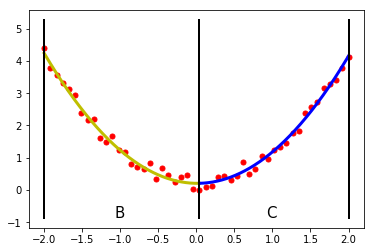

In [167]:
features(x,y)

In [168]:
x = [0,         0.33069396, 0.66138793, 0.99208189, 1.32277585, 1.65346982,
 1.98416378, 2.31485774, 2.64555171, 2.97624567, 3.30693964, 3.6376336,
 3.96832756, 4.29902153, 4.62971549, 4.96040945, 5.29110342, 5.62179738,
 5.95249134, 6.28318531]
y = [1.10648495, 1.16479219, 0.96480881, 0.96440633, 0.96712967, 1.00458371,
 0.99468688, 0.9059453,  0.87729989, 0.86951913, 0.84886777, 0.70607027,
 0.71304545, 0.62777343, 0.61424892, 0.50857203, 0.56674262, 0.61784323,
 0.55325281, 0.53578219]

Primitives: ['F']

Extremes of the primitives: [0.         6.28318531]

Value at extremes of the primitives: [1.1215786  0.48960696]

Extrema: [' ', ' ']



(['F'],
 array([0.        , 6.28318531]),
 array([1.1215786 , 0.48960696]),
 [' ', ' '])

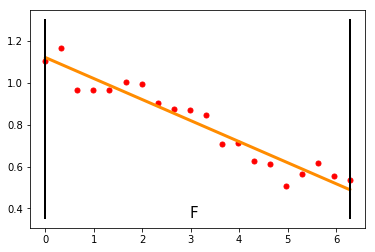

In [169]:
features(x,y)

In [48]:
x = [0, 1, 2, 3, 4]
y = [0.26790572, 1.08639212, 2.31397397, 2.57607642, 2.23173787]

Primitives: ['A', 'D']

Extremes of the primitives: [0.         3.17171717 4.        ]

Value at extremes of the primitives: [0.14158617 2.47739138 2.30852561]

Extrema: [' ', 'maximum', ' ']



(['A', 'D'],
 array([0.        , 3.17171717, 4.        ]),
 array([0.14158617, 2.47739138, 2.30852561]),
 [' ', 'maximum', ' '])

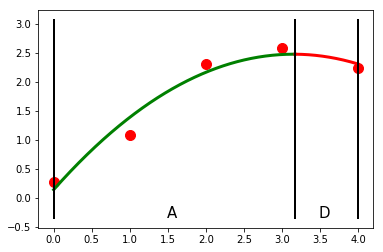

In [49]:
features(x,y)

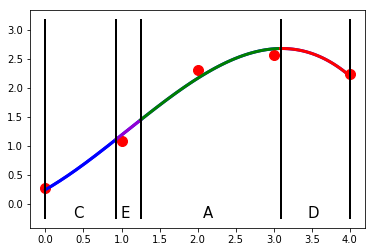

In [44]:
sp = smoothcurve(x,y)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)

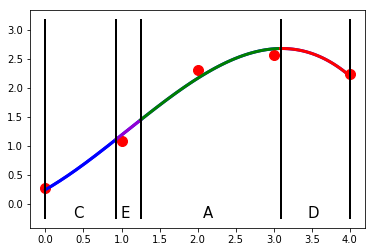

In [45]:
sp = smoothcurve(x,y)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)

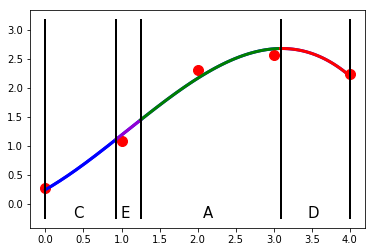

In [46]:
sp = smoothcurve(x,y)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)

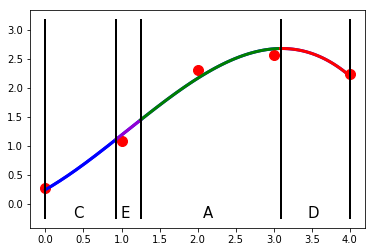

In [47]:
sp = smoothcurve(x,y)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)

In [175]:
x = [0, 2, 4, 6, 8, 10]
y = [0.01554831, 0.82824344, 0.94180897, 0.9941693, 0.99203798, 0.99647302]

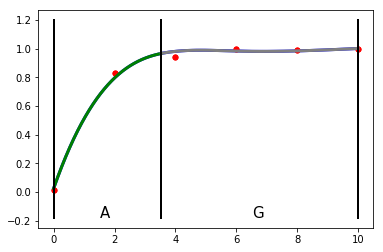

In [176]:
sp = smoothcurve(x,y)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)

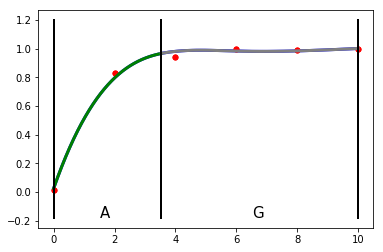

In [177]:
sp = smoothcurve(x,y)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)

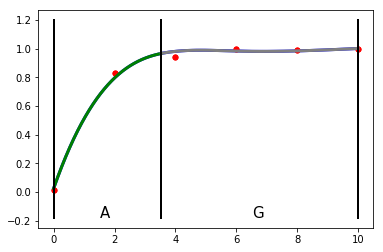

In [178]:
sp = smoothcurve(x,y)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)

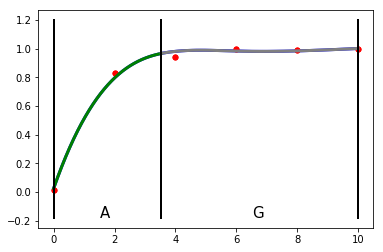

In [179]:
sp = smoothcurve(x,y)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)

In [41]:
x = [-7, -5, -3, -1, 1, 3, 5, 7]
y = [0.04791213, 0.05324336, 0.0677637, 0.26345582, 0.6925348, 0.90531751, 0.98343193, 0.97689233]

Primitives: ['G', 'C', 'A', 'G']

Extremes of the primitives: [-7.         -3.04040404  0.07070707  4.03030303  7.        ]

Value at extremes of the primitives: [0.04779445 0.06137738 0.4926507  0.96077174 0.97719425]

Extrema: [' ', ' ', ' ', ' ', ' ']



(['G', 'C', 'A', 'G'],
 array([-7.        , -3.04040404,  0.07070707,  4.03030303,  7.        ]),
 array([0.04779445, 0.06137738, 0.4926507 , 0.96077174, 0.97719425]),
 [' ', ' ', ' ', ' ', ' '])

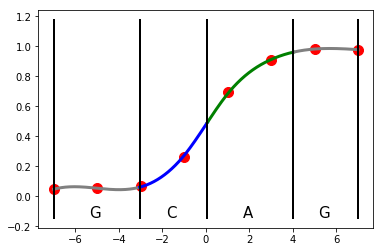

In [42]:
features(x,y)

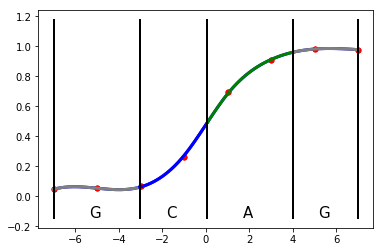

In [181]:
sp = smoothcurve(x,y)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)

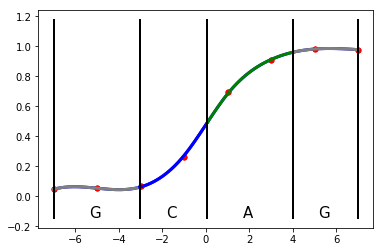

In [182]:
sp = smoothcurve(x,y)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)

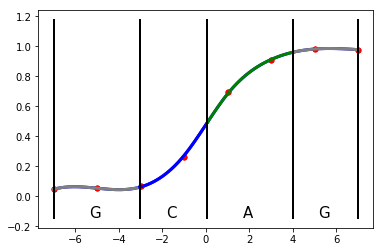

In [183]:
sp = smoothcurve(x,y)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)

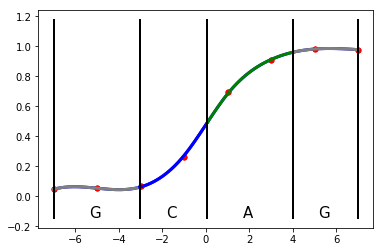

In [184]:
sp = smoothcurve(x,y)

m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, sp(xs), 'b', lw=3)

shape1, shape2, limits = primitives(sp,x)      # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)     # Primitives of the simplified cuve
primitivesvisual(x,y,sp,limits,p_string)

In [185]:
x = np.linspace(-0.1,0.5,8)
y = 1 - np.square(x) + np.random.random(8) * 0.05

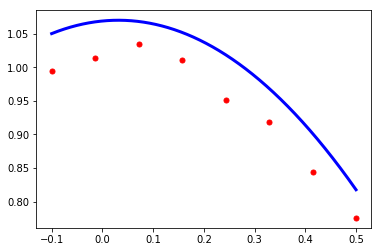

In [186]:
pol2 = polynomial(x,y,2)
m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, pol2(xs)+0.05, 'b', lw=3)

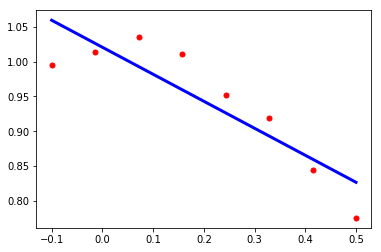

In [187]:
pol1 = polynomial(x,y,1)
m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, pol1(xs), 'b', lw=3)

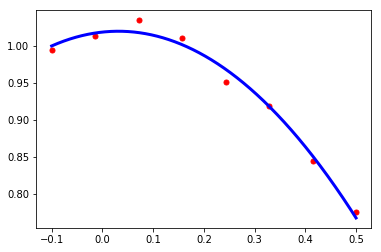

In [188]:
pol3 = polynomial(x,y,2)
m = len(x)
xs = np.linspace(x[0],x[m-1],1000) 
plt.plot(x, y, 'ro', ms=5) 
plt.plot(xs, pol3(xs), 'b', lw=3)

In [189]:
df1 = pd.DataFrame({'Index': xs, 'pol1': pol1(xs), 'pol2': pol2(xs), 'pol3': pol3(xs)})
df2 = pd.DataFrame({'Index': x, 'Data': y})
writer = pd.ExcelWriter('figure_defense.xlsx', engine='xlsxwriter')
df1.to_excel(writer, sheet_name = 'Sheet1')
df2.to_excel(writer, sheet_name = 'Sheet2')
writer.save()

In [190]:
x = [96.582612, 193.162590, 386.328868, 386.328868]
y = [9.279016, 11.321325, 23.768149, 23.777566]

Primitives: ['E']

Extremes of the primitives: [ 96.582612   386.32886803]

Value at extremes of the primitives: [ 8.03951245 23.46299175]

Extrema: [' ', ' ']



(['E'],
 array([ 96.582612  , 386.32886803]),
 array([ 8.03951245, 23.46299175]),
 [' ', ' '])

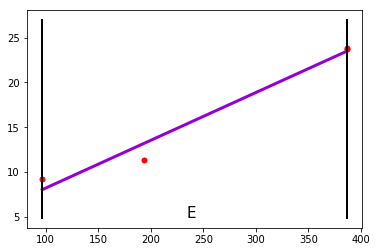

In [191]:
features(x,y)

In [192]:
x = [548, 548, 573, 598, 623, 623]
y = [5.273463, 5.204347, 11.321325, 22.185933, 35.956045, 35.252754]

Primitives: ['G', 'C']

Extremes of the primitives: [548.         560.12121212 623.00000001]

Value at extremes of the primitives: [ 6.14068674  8.41163825 36.27287904]

Extrema: [' ', ' ', ' ']



(['G', 'C'],
 array([548.        , 560.12121212, 623.00000001]),
 array([ 6.14068674,  8.41163825, 36.27287904]),
 [' ', ' ', ' '])

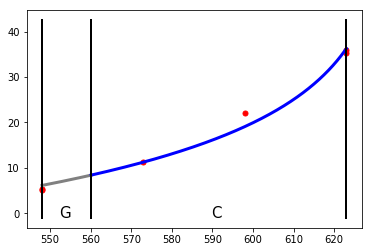

In [193]:
features(x,y)

In [37]:
x = [-7, -5, -3, -1, 1, 3, 5, 7]
y = [0.04791213, 0.05324336, 0.0677637, 0.26345582, 0.6925348, 0.90531751, 0.98343193, 0.97689233]

In [38]:
x = [0, 1, 2, 3, 4]
y = [0.26790572, 1.08639212, 2.31397397, 2.57607642, 2.23173787]

In [39]:
x = [15.83, 23.97, 24.54, 26.68, 27.12]
y = [0, 5, 6, 12, 17]

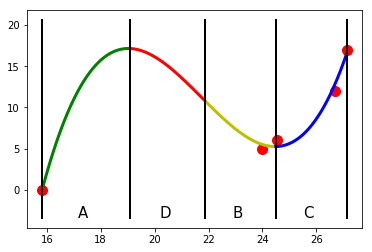

In [40]:
n = len(x)
sp = UnivariateSpline(x,y,None,[None,None],3,n)

shape1, shape2, extremes = primitives(sp,x)     # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)      # Primitives of the simplified cuve
primitivesvisual(x,y,sp,extremes,p_string)      # The curve is now visualised (see the function 'primitivesvisual' for more information)

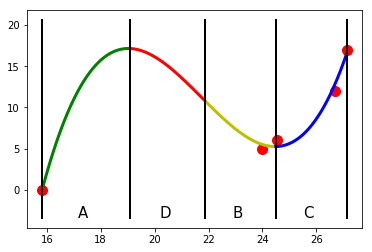

In [41]:
n = len(x)
sp = smoothcurve(x,y)

shape1, shape2, extremes = primitives(sp,x)     # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)      # Primitives of the simplified cuve
too_complex = primcomplex(p_string)              # Based on the list of strings, it decided whether the curve is too complex or not (see the function 't
primitivesvisual(x,y,sp,extremes,p_string)      # The curve is now visualised (see the function 'primitivesvisual' for more information)

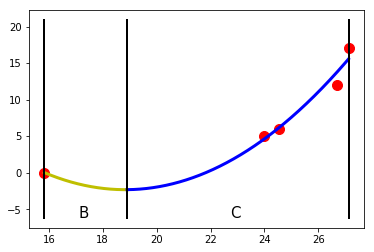

In [42]:
n = len(x)
sp = simplifysmoothcurve(x,y,sp,too_complex) 

shape1, shape2, extremes = primitives(sp,x)      # Lists containing the information on the shape of the curve (see the function 'primitives' for more information)
p_string = primitivesstring(shape1,shape2)       # List of strings with letters representing the primitives (see the function 'primitivesstring' for more information)
primitivesvisual(x,y,sp,extremes,p_string)      # The curve is now visualised (see the function 'primitivesvisual' for more information)

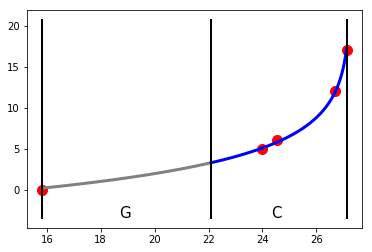

In [43]:
A, B, C, sign_x = log_fit(x, y)
    
choose_log = log_simplify(x, y, sp, A, B, C, sign_x)
    
if choose_log == True:
        
    shape1, shape2, extremes = log_primitives(A, B, C, sign_x, x)      # Shapes of the simplified curve
    p_string = primitivesstring(shape1,shape2)                         # Primitives of the simplified cuve
    
    log_primitivesvisual(x, y, A, B, C, sign_x, extremes, p_string)    # The curve is now visualised (see the function 'primitivesvisual' for more information)
        
else:
    
    shape1, shape2, extremes = primitives(sp,x)      # Shapes of the simplified curve
    p_string = primitivesstring(shape1,shape2)       # Primitives of the simplified cuve
    
    primitivesvisual(x,y,sp,extremes,p_string)       # The curve is now visualised (see the function 'primitivesvisual' for more information)

In [44]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [0.36026563, 1.24239091, 2.9502977, 3.26805166, 4.83087873, 5.37428958, 6.45681833, 7.99143781, 8.06068076, 9.1383204]

In [45]:
n = len(x)
sp = smoothcurve(x,y)
pol3 = polynomial(x,y,3)
pol2 = polynomial(x,y,2)
pol1 = polynomial(x,y,1)
xs = np.linspace(x[0],x[n-1],1000)

[0. 9.]
0.9988181089982466


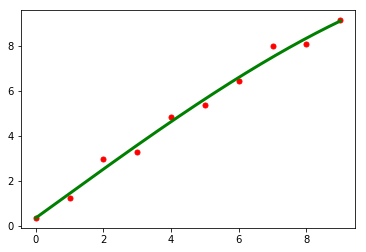

In [46]:
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, sp(xs), 'g', lw=3)
k1 = sp.get_knots()
print(k1)
R = rvalue(sp, x)
print(R)

[0. 9.]
0.9988181089982466


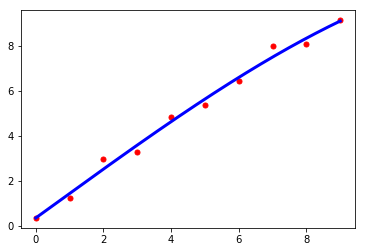

In [47]:
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, pol3(xs), 'b', lw=3)
k1 = pol3.get_knots()
print(k1)
R = rvalue(pol3, x)
print(R)

[0. 9.]
0.9988049550663407


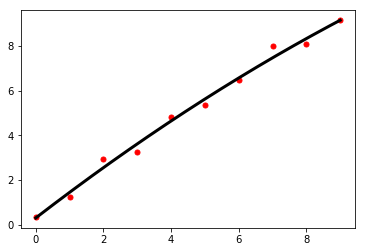

In [48]:
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, pol2(xs), 'k', lw=3)
k1 = pol2.get_knots()
print(k1)
R = rvalue(pol2, x)
print(R)

[0. 9.]
0.9984745860210033


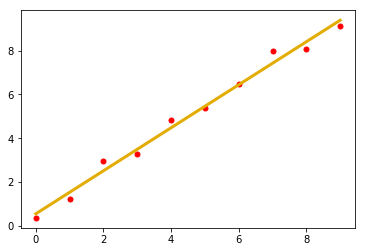

In [49]:
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, pol1(xs), '#e3ac00', lw=3)
k1 = pol1.get_knots()
print(k1)
R = rvalue(pol1, x)
print(R)

In [50]:
x = [0, 2, 4, 6, 8, 10, 12]
y = [0.01554831, 0.82824344, 0.94180897, 0.9901693, 0.99203798, 0.99647302, 0.996874374]

In [51]:
n = len(x)
sp = smoothcurve(x,y)
pol3 = polynomial(x,y,3)
pol2 = polynomial(x,y,2)
pol1 = polynomial(x,y,1)
xs = np.linspace(x[0],x[n-1],1000)

[ 0.  4.  6.  8. 12.]
0.9999951659933366


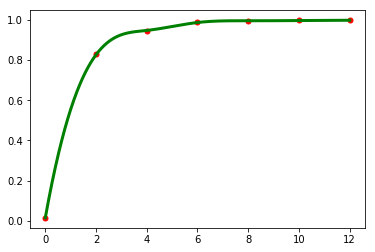

In [52]:
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, sp(xs), 'g', lw=3)
k1 = sp.get_knots()
print(k1)
R = rvalue(sp, x)
print(R)

[ 0. 12.]
0.9975721497911041


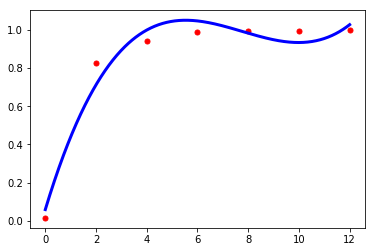

In [53]:
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, pol3(xs), 'b', lw=3)
k1 = pol3.get_knots()
print(k1)
R = rvalue(pol3, x)
print(R)

[ 0. 12.]
0.98873309063391


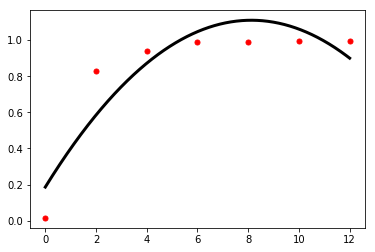

In [54]:
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, pol2(xs), 'k', lw=3)
k1 = pol2.get_knots()
print(k1)
R = rvalue(pol2, x)
print(R)

[ 0. 12.]
0.9643595850746405


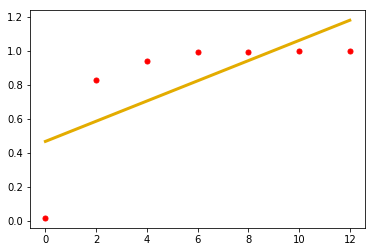

In [55]:
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, pol1(xs), '#e3ac00', lw=3)
k1 = pol1.get_knots()
print(k1)
R = rvalue(pol1, x)
print(R)

In [56]:
x = [0, 1, 2, 3, 4]
y = [0.26790572, 1.18639212, 2.31397397, 2.57607642, 2.23173787]

In [57]:
n = len(x)
sp = smoothcurve(x,y)
pol3 = polynomial(x,y,3)
pol2 = polynomial(x,y,2)
pol1 = polynomial(x,y,1)
xs = np.linspace(x[0],x[n-1],1000)

[0. 4.]
0.9993112352874416


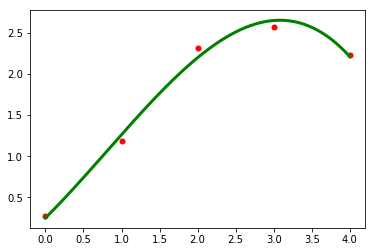

In [58]:
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, sp(xs), 'g', lw=3)
k1 = sp.get_knots()
print(k1)
R = rvalue(sp, x)
print(R)

[0. 4.]
0.9993112352874416


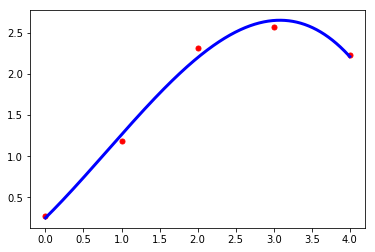

In [59]:
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, pol3(xs), 'b', lw=3)
k1 = pol3.get_knots()
print(k1)
R = rvalue(pol3, x)
print(R)

[0. 4.]
0.9975059827177036


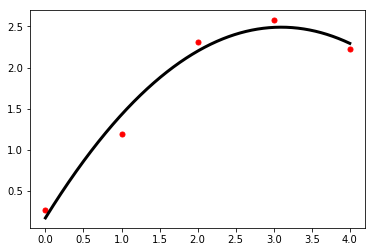

In [60]:
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, pol2(xs), 'k', lw=3)
k1 = pol2.get_knots()
print(k1)
R = rvalue(pol2, x)
print(R)

[0. 4.]
0.9749352255929008


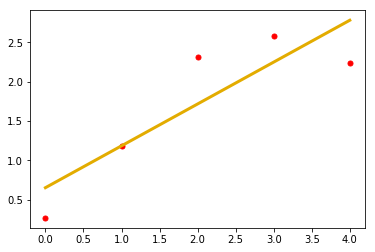

In [61]:
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, pol1(xs), '#e3ac00', lw=3)
k1 = pol1.get_knots()
print(k1)
R = rvalue(pol1, x)
print(R)

In [62]:
x = [0, 0.57142857, 1.14285714, 1.71428571, 2.28571429, 2.85714286, 3.42857143, 4]
y = [1.56950377, 3.47825476, 5.20448204, 9.0572316, 12.57019727, 18.10516025, 25.63150773, 33.21730569]

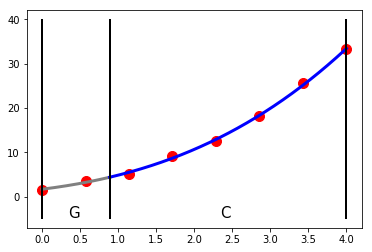

In [63]:
n = len(x)
sp = polynomial(x,y,3)

shape1, shape2, extremes = primitives(sp,x)     # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)      # Primitives of the simplified cuve
too_complex = primcomplex(p_string)              # Based on the list of strings, it decided whether the curve is too complex or not (see the function 't
primitivesvisual(x,y,sp,extremes,p_string)      # The curve is now visualised (see the function 'primitivesvisual' for more information)

In [64]:
x = [2, 3, 4, 5, 6, 7, 8, 9]
y = [4.07990295, 4.0, 4.25804966, 5.66328649, 6.01512934, 7.18739731, 8.18887299, 9.60215194]

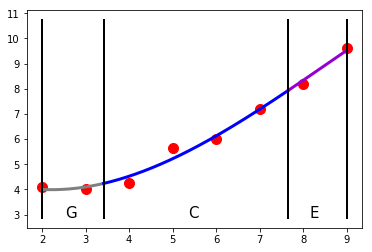

In [65]:
n = len(x)
sp = polynomial(x,y,3)

shape1, shape2, extremes = primitives(sp,x)     # Shapes of the simplified curve
p_string = primitivesstring(shape1,shape2)      # Primitives of the simplified cuve
too_complex = primcomplex(p_string)              # Based on the list of strings, it decided whether the curve is too complex or not (see the function 't
primitivesvisual(x,y,sp,extremes,p_string)      # The curve is now visualised (see the function 'primitivesvisual' for more information)

In [66]:
x = [9.271779, 11.321484, 23.763524, 23.763524]
y = [75.000000, 69.039493, 60.766551, 60.348432]

In [67]:
log_fit(x, y)

(array([-4.39049004]), array([72.60039199]), 8.734003089108622, 1)

In [68]:
x_orig = [9.271779, 11.321484, 23.763524]
y_orig = [75.0, 69.039493, 60.5574915]

In [69]:
C_min = estimate_C(x_orig, y_orig, -1)

print(C_min)

23.76352414491745
